# Fig panels and tables for main text and supplement

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import seaborn as sns
import seaborn.objects as so
import textwrap
import copy
from scipy import stats
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import string
import statsmodels.api as sm
import textwrap
import itertools
import skbio
from skbio.stats import composition
from sklearn.manifold import MDS
import scikit_posthocs as skp
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 200

In [2]:
#packages used version numbers
import types
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.2.2
matplotlib==3.8.4
numpy==1.26.4
seaborn==0.13.2
statsmodels.api==0.14.2
skbio==0.6.0
scikit_posthocs==0.9.0


In [3]:
#import the data
#metagenome relative abundances pre-calculated
relabun = pd.read_csv("SupplementaryData4.csv") 
relabun.set_index("Consensus Genome", inplace=True)
relabun.drop("GC", axis=1, inplace=True)
relabun.drop("Lineage Designation", axis=1, inplace=True)

#normalized metatranscriptome counts pre-calculated in Rstudio edgeR pipeline #combined file = SupplementaryData9 
#exported as Geneclusters_mincount1_{sample}_consensusMAGs_bowtie_normalized_CPM.csv from edgeR Rmd file
ms2005cpm = pd.read_excel("SupplementaryData9.xlsx",sheet_name="Normalized_CPM_MS2005")
ms2009cpm = pd.read_excel("SupplementaryData9.xlsx",sheet_name="Normalized_CPM_MS2009")
os2009cpm = pd.read_excel("SupplementaryData9.xlsx",sheet_name="Normalized_CPM_OS2009")

#WGCNA modules and eigengenes exported from Rscript
wgcna = pd.read_csv("SupplementaryData12.tsv",sep="\t")
eigengenesms2005 = pd.read_csv("2023_03_27_consensuswgcna_allthree_eignegenes_MS2005_v1.tsv",sep="\t")
eigengenesms2009 =  pd.read_csv("2023_03_27_consensuswgcna_allthree_eignegenes_MS2009_v1.tsv",sep="\t")
eigengenesos2009 = pd.read_csv("2023_03_27_consensuswgcna_allthree_eignegenes_OS2009_v1.tsv",sep="\t")


In [4]:
#import metadata
#sample metadata
metadata = pd.read_excel("SupplementaryData1.xlsx") 

#annotation metadata
gcanno = pd.read_csv("Anvioselectedannotations.csv") #all 6 source annotations from anvi'o on a single line, randomly picked 1 gene per gene cluster for annotation
#simplify the annotation for cog analysis #deposited on figshare
gcanno["primary_COG_CATEGORY"]=gcanno["accession_COG_CATEGORY"].fillna("").str[0]
gcanno["primary_COG_PATHWAY"]= gcanno["function_COG_PATH"].str.split("!!!").str[0]

#import gff used for read mapping (deposited on figshare)
gff = pd.read_csv("selectedMAGs_metatranscriptome.gff", sep="\t", names=["scaffold_id","annot_source","type","start","end", "score", "strand", "frame", "attribute"])

#split attributes
gff['Lineage'] = [x.split('|')[0].split(':')[1] for x in gff["attribute"]]
gff['Gene Cluster'] = [x.split('|')[1].split(':')[1] for x in gff["attribute"]]
gff['MAG Sample Name'] = [x.split('|')[2].split(':')[1] for x in gff["attribute"]]
gff['MAG Bin Number'] = [int(x.split('|')[3].split(':')[1]) for x in gff["attribute"]]
gff['MAG Gene Callers ID'] = [int(x.split('|')[4].split(':')[1].split(";")[0]) for x in gff["attribute"]]
#extract gene length per bin, bin length by summing gene lengths
gff["length"] = abs(gff["end"]-gff["start"])


In [5]:
#helper data structures
#metatranscriptome sample names in time order
ms2005names =["MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12"]
ms2009names = ["MetofsampleR2cd","MetofsampleR3cd","MetofsampleR5cd","MetofsampleR6cd",
                "MetofsampleR7cd","MetofsampleR8cd","MetofsampleR9cd","MetofsamplR10cd",
                "MetofsamplR11cd","MetofsamplR12cd","MetofsamplR13cd","MetofsamplR14cd"]
os2009names = ["Metofsamplet1cd","Metofsamplet2cd", "Metofsamplet4cd","Metofsamplet5cd",
                "Metofsamplet8cd","Metofsamplt11cd", "Metofsamplt13cd", "Metofsamplt14cd"]

#string times lists for plot axes (in sample order)
ms2005times = ["18:00","20:00","22:00","00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00"]
ms2009times = ["19:25","20:05","22:10","00:00","05:00","06:15","07:40","08:40","10:07","12:20","14:05","16:00"]
os2009times = ["16:00","17:45","19:15","20:00","05:00","07:15","10:00","12:00"]

#create datetimes for plotting, convert all to same dates to make it easier to plot multiple time series sharing same axes
ms2009dt = pd.to_datetime(["2009-07-29 19:25","2009-07-29 20:05","2009-07-29 22:10","2009-07-30 00:00","2009-07-30 05:00","2009-07-30 06:15","2009-07-30 07:40","2009-07-30 08:40","2009-07-30 10:07","2009-07-30 12:20","2009-07-30 14:05","2009-07-30 16:00"])
ms2005dtfake = pd.to_datetime(["2009-07-29 18:00","2009-07-29 20:00","2009-07-29 22:00","2009-07-30 00:01","2009-07-30 02:00","2009-07-30 04:00","2009-07-30 06:00","2009-07-30 08:00","2009-07-30 10:00","2009-07-30 12:00","2009-07-30 14:00","2009-07-30 16:00"])
os2009dtfake = pd.to_datetime(["2009-07-29 16:00","2009-07-29 17:45","2009-07-29 19:15","2009-07-29 20:00",
                               "2009-07-30 05:00","2009-07-30 07:15","2009-07-30 10:00","2009-07-30 12:00"]) 

#colors for plots
lineagecolors = {'Acidobacteriota-sp-001':"tab:blue",
 'Acidobacteriota-sp-005':"tab:orange",
 'Acidobacteriota-sp-006':"tab:green",
 'Acidobacteriota-sp-004':"tab:red",
 'Acidobacteriota-sp-002':"tab:purple",
 'Actinobacteriota-sp-001':"tab:brown",
 'Acidobacteriota-sp-003':"tab:pink",
 'Acquificota-sp-001':"tab:gray",
 'Armatimonadota-sp-004':"tab:olive",
 'Armatimonadota-sp-003':"tab:gray",
 'Armatimonadota-sp-002':"tab:olive",
 'Bacteroidota-sp-007':"tab:orange",
 'Bacteroidota-sp-009':"tab:green",
 'Bacteroidota-sp-004':"tab:purple",
 'Caldatribacteriota-sp-001':"tab:purple",
 'Bacteroidota-sp-001':"tab:brown",
 'Bacteroidota-sp-002':"tab:pink",
 'Chloroflexota-sp-003':"tab:gray",
 'Chloroflexota-sp-002':"tab:orange",
 'Chloroflexota-sp-001':"tab:cyan",
 'Chloroflexota-sp-005':"tab:blue",
 'Chloroflexota-sp-009':"tab:orange",
 'Chloroflexota-sp-007':"tab:green",
 'Chloroflexota-sp-004':"tab:red",
 'Chloroflexota-sp-006':"tab:purple",
 'Chloroflexota-sp-008':"tab:brown",
 'Cyanobacteria-sp-003':"tab:pink",
 'Cyanobacteria-sp-004':"tab:gray",
 'Cyanobacteria-sp-002':"tab:olive",
 'Cyanobacteria-sp-001':"tab:green",
 'Deinococcota-sp-001':"tab:blue",
 'Deinococcota-sp-002':"tab:orange",
 'Armatimonadota-sp-005':"tab:green",
 'Bacteroidota-sp-006':"tab:red",
 'Bacteroidota-sp-008':"tab:purple",
 'Microgenomates-sp-001':"tab:brown",
 'Nitrospirota-sp-001':"tab:purple",
 'Nitrospirota-sp-002':"tab:gray",
 'Planctomycetota-sp-009':"tab:olive",
 'Planctomycetota-sp-010':"tab:cyan",
 'Planctomycetota-sp-007':"tab:red",
 'Planctomycetota-sp-008':"tab:blue",
 'Planctomycetota-sp-001':"tab:orange",
 'Planctomycetota-sp-004':"tab:green",
 'Planctomycetota-sp-002':"tab:olive",
 'Planctomycetota-sp-006':"tab:purple",
 'Planctomycetota-sp-005':"tab:brown",
 'Planctomycetota-sp-003':"tab:pink",
 'Proteobacteria-sp-004':"tab:gray",
 'Proteobacteria-sp-003':"tab:olive",
 'Desulfobacterota-sp-002':"tab:cyan",
 'Proteobacteria-sp-002':"tab:blue",
 'Spirochaetota-sp-007':"tab:orange",
 'Proteobacteria-sp-001':"tab:pink",
 'Spirochaetota-sp-001':"tab:red",
 'Spirochaetota-sp-003':"tab:gray",
 'Spirochaetota-sp-005':"tab:brown",
 'Spirochaetota-sp-002':"tab:pink",
 'Thaumarchaeota-sp-001':"tab:gray",
 'Desulfobacterota-sp-001':"tab:olive",
 'Termotogota-sp-001':"tab:cyan",
 'Verrucomicrobiota-sp-001':"tab:blue",
 'Armatimonadota-sp-001':"tab:orange",
 'Bacteroidota-sp-003':"tab:green",
 'Bacteroidota-sp-005':"tab:olive",
 'Bacteroidota-sp-010':"tab:purple",
 'Spirochaetota-sp-006':"tab:brown",
 'Bacteroidota-sp-011':"tab:pink",
 'Verrucomicrobiota-sp-002':"tab:olive",
 'Spirochaetota-sp-004':"tab:cyan",
 'Elusimicrobiota-sp-001':"tab:blue"}

#genomes at least 1% CPM in 1 or more samples across all time series in metatranscriptome(19)
onepctgenomes = ["Acidobacteriota-sp-001","Acquificota-sp-001","Armatimonadota-sp-002","Armatimonadota-sp-003","Bacteroidota-sp-001",
                "Bacteroidota-sp-002","Bacteroidota-sp-003","Bacteroidota-sp-004","Bacteroidota-sp-005","Caldatribacteriota-sp-001",
                "Chloroflexota-sp-001","Chloroflexota-sp-002","Chloroflexota-sp-008","Chloroflexota-sp-009","Cyanobacteria-sp-001",
                 "Nitrospirota-sp-001","Planctomycetota-sp-007","Spirochaetota-sp-003","Termotogota-sp-001"] 

#genomes at least 1 pct in all samples across all three timeseries (8)
strictonepctgenomes = ["Acidobacteriota-sp-001","Armatimonadota-sp-002","Armatimonadota-sp-003","Bacteroidota-sp-002","Chloroflexota-sp-001",
                      "Chloroflexota-sp-008","Chloroflexota-sp-009","Cyanobacteria-sp-001"]

strictonepctnames = {"Cyanobacteria-sp-001":"SYNCO", "Armatimonadota-sp-002":"ARMA03","Armatimonadota-sp-003":"ARMA12",
                     "Acidobacteriota-sp-001":"CHLAB", "Bacteroidota-sp-002":"THMCO","Chloroflexota-sp-008":"ROSLN",
                     "Chloroflexota-sp-009":"ROSEI","Chloroflexota-sp-001":"CHLFL"}

strictonepctplotorder=["Cyanobacteria-sp-001","Acidobacteriota-sp-001","Bacteroidota-sp-002",
                       "Chloroflexota-sp-001","Chloroflexota-sp-008","Chloroflexota-sp-009", "Armatimonadota-sp-002","Armatimonadota-sp-003"]


#metagenome sample order by spring/year
altmetaGsampleorder= ["Hotspr2Sample148","Hotspr2Sample149","Hotspr2Sampleee2","Hotspr2Sampleme2",
                      "Hotspr20SampleP4","Hotspr2SamplePe2","Hotspr20SampleT8","Hotspr20SampleT9",
                      "HotsprSampleMSe1","HotsprSampleMSe2","HotsprSampleMSe3","HotsprSampleMSe4",
                      "HotsprSampleMS13","HotsprSampleR4cd","HotsprSampleMS50","HotsprSampleMS55",
                      "HotsprSampleMS60","HotsprSampleMS65","Hotspr20Samplet1","Hotspr20Samplem2",
                      "HotsprSampleOSM1","HotsprSampleOSM2","HotsprSampleOSM3","HotsprSampleOSM4",
                      "HotsprSampOS1260","HotsprSampOS1265","HotsprottomLayer","HotsprOSTMatCore",
                      "HotsprottomLayer_2","HotsprSamplt10cd","HotsprSampleOS50","HotsprSampleOS65",
                      "HotsprSampleOS60","HotsprSampleOS55"]


#define colorblocks for clustermaps
#temp
tempcolors={"Hotspr2Sample148":"mediumvioletred","Hotspr2Sample149":"mediumvioletred",
            "Hotspr2Sampleee2":"mediumvioletred","Hotspr2Sampleme2":"mediumvioletred",
            "Hotspr20SampleP4":"mediumvioletred","Hotspr2SamplePe2":"mediumvioletred",
            "Hotspr20SampleT8":"mediumvioletred","Hotspr20SampleT9":"mediumvioletred",
            "HotsprSampleMSe1":"mediumvioletred","HotsprSampleMSe2":"mediumvioletred",
            "HotsprSampleMSe3":"mediumvioletred","HotsprSampleMSe4":"mediumvioletred",
            "HotsprSampleMS13":"mediumvioletred","HotsprSampleR4cd":"mediumvioletred",
            "HotsprSampleMS50":"blue","HotsprSampleMS55":"blueviolet",
            "HotsprSampleMS60":"mediumvioletred","HotsprSampleMS65":"red",
            "Hotspr20Samplet1":"mediumvioletred","Hotspr20Samplem2":"mediumvioletred",
            "HotsprSampleOSM1":"mediumvioletred","HotsprSampleOSM2":"mediumvioletred",
            "HotsprSampleOSM3":"mediumvioletred","HotsprSampleOSM4":"mediumvioletred",
            "HotsprSampOS1260":"mediumvioletred","HotsprSampOS1265":"red",
            "HotsprottomLayer":"blueviolet","HotsprOSTMatCore":"blueviolet",
            "HotsprottomLayer_2":"blueviolet","HotsprSamplt10cd":"mediumvioletred",
            "HotsprSampleOS50":"blue","HotsprSampleOS65":"blueviolet",
            "HotsprSampleOS60":"mediumvioletred","HotsprSampleOS55":"red"}
#bottomlayer
bottomlayercolors ={"Hotspr2Sample148":"brown","Hotspr2Sample149":"brown",
            "Hotspr2Sampleee2":"white","Hotspr2Sampleme2":"white",
            "Hotspr20SampleP4":"white","Hotspr2SamplePe2":"white",
            "Hotspr20SampleT8":"white","Hotspr20SampleT9":"white",
            "HotsprSampleMSe1":"white","HotsprSampleMSe2":"white",
            "HotsprSampleMSe3":"white","HotsprSampleMSe4":"white",
            "HotsprSampleMS13":"white","HotsprSampleR4cd":"white",
            "HotsprSampleMS50":"white","HotsprSampleMS55":"white",
            "HotsprSampleMS60":"white","HotsprSampleMS65":"white",
            "Hotspr20Samplet1":"white","Hotspr20Samplem2":"white",
            "HotsprSampleOSM1":"white","HotsprSampleOSM2":"white",
            "HotsprSampleOSM3":"white","HotsprSampleOSM4":"white",
            "HotsprSampOS1260":"white","HotsprSampOS1265":"white",
            "HotsprottomLayer":"brown","HotsprOSTMatCore":"brown",
            "HotsprottomLayer_2":"brown","HotsprSamplt10cd":"white",
            "HotsprSampleOS50":"white","HotsprSampleOS65":"white",
            "HotsprSampleOS60":"white","HotsprSampleOS55":"white"}
#spring
springcolors={"Hotspr2Sample148":"mediumseagreen","Hotspr2Sample149":"mediumseagreen",
            "Hotspr2Sampleee2":"mediumseagreen","Hotspr2Sampleme2":"mediumseagreen",
            "Hotspr20SampleP4":"mediumseagreen","Hotspr2SamplePe2":"mediumseagreen",
            "Hotspr20SampleT8":"mediumseagreen","Hotspr20SampleT9":"mediumseagreen",
            "HotsprSampleMSe1":"mediumseagreen","HotsprSampleMSe2":"mediumseagreen",
            "HotsprSampleMSe3":"mediumseagreen","HotsprSampleMSe4":"mediumseagreen",
            "HotsprSampleMS13":"mediumseagreen","HotsprSampleR4cd":"mediumseagreen",
            "HotsprSampleMS50":"mediumseagreen","HotsprSampleMS55":"mediumseagreen",
            "HotsprSampleMS60":"mediumseagreen","HotsprSampleMS65":"mediumseagreen",
            "Hotspr20Samplet1":"darkorange","Hotspr20Samplem2":"darkorange",
            "HotsprSampleOSM1":"darkorange","HotsprSampleOSM2":"darkorange",
            "HotsprSampleOSM3":"darkorange","HotsprSampleOSM4":"darkorange",
            "HotsprSampOS1260":"darkorange","HotsprSampOS1265":"darkorange",
            "HotsprottomLayer":"darkorange","HotsprOSTMatCore":"darkorange",
            "HotsprottomLayer_2":"darkorange","HotsprSamplt10cd":"darkorange",
            "HotsprSampleOS50":"darkorange","HotsprSampleOS65":"darkorange",
            "HotsprSampleOS60":"darkorange","HotsprSampleOS55":"darkorange"}
#year 
yearcolors ={"Hotspr2Sample148":"lightyellow","Hotspr2Sample149":"lightyellow",
            "Hotspr2Sampleee2":"greenyellow","Hotspr2Sampleme2":"greenyellow",
            "Hotspr20SampleP4":"greenyellow","Hotspr2SamplePe2":"greenyellow",
            "Hotspr20SampleT8":"greenyellow","Hotspr20SampleT9":"greenyellow",
            "HotsprSampleMSe1":"springgreen","HotsprSampleMSe2":"springgreen",
            "HotsprSampleMSe3":"springgreen","HotsprSampleMSe4":"springgreen",
            "HotsprSampleMS13":"springgreen","HotsprSampleR4cd":"paleturquoise",
            "HotsprSampleMS50":"paleturquoise","HotsprSampleMS55":"paleturquoise",
            "HotsprSampleMS60":"paleturquoise","HotsprSampleMS65":"paleturquoise",
            "Hotspr20Samplet1":"greenyellow","Hotspr20Samplem2":"greenyellow",
            "HotsprSampleOSM1":"springgreen","HotsprSampleOSM2":"springgreen",
            "HotsprSampleOSM3":"springgreen","HotsprSampleOSM4":"springgreen",
            "HotsprSampOS1260":"springgreen","HotsprSampOS1265":"springgreen",
            "HotsprottomLayer":"aquamarine","HotsprOSTMatCore":"aquamarine",
            "HotsprottomLayer_2":"aquamarine","HotsprSamplt10cd":"paleturquoise",
            "HotsprSampleOS50":"paleturquoise","HotsprSampleOS65":"paleturquoise",
            "HotsprSampleOS60":"paleturquoise","HotsprSampleOS55":"paleturquoise"}

#phylum
phylumcolors = {'Acidobacteriota-sp-001':"lightcoral", 'Acidobacteriota-sp-002':"lightcoral",
       'Acidobacteriota-sp-003':"lightcoral", 'Acidobacteriota-sp-004':"lightcoral",
       'Acidobacteriota-sp-005':"lightcoral", 'Acidobacteriota-sp-006':"lightcoral",
       'Acquificota-sp-001':"darkturquoise", 'Actinobacteriota-sp-001':"chocolate",
       'Armatimonadota-sp-001':"sandybrown", 'Armatimonadota-sp-002':"sandybrown",
       'Armatimonadota-sp-003':"sandybrown", 'Armatimonadota-sp-004':"sandybrown",
       'Armatimonadota-sp-005':"sandybrown", 'Bacteroidota-sp-001':"deepskyblue",
                    'Bacteroidota-sp-002':"deepskyblue",
       'Bacteroidota-sp-003':"deepskyblue", 'Bacteroidota-sp-004':"deepskyblue", 
                    'Bacteroidota-sp-005':"deepskyblue",
       'Bacteroidota-sp-006':"deepskyblue", 'Bacteroidota-sp-007':"deepskyblue",
                    'Bacteroidota-sp-008':"deepskyblue",
       'Bacteroidota-sp-009':"deepskyblue", 'Bacteroidota-sp-010':"deepskyblue",
                    'Bacteroidota-sp-011':"deepskyblue",
       'Caldatribacteriota-sp-001':"khaki", 'Chloroflexota-sp-001':"orange",
       'Chloroflexota-sp-002':"orange", 'Chloroflexota-sp-003':"orange",
                    'Chloroflexota-sp-004':"orange",
       'Chloroflexota-sp-005':"orange", 'Chloroflexota-sp-006':"orange",
                    'Chloroflexota-sp-007':"orange",
       'Chloroflexota-sp-008':"orange", 'Chloroflexota-sp-009':"orange",
                    'Cyanobacteria-sp-001':"green",
       'Cyanobacteria-sp-002':"green", 'Cyanobacteria-sp-003':"green",
                    'Cyanobacteria-sp-004':"green",
       'Deinococcota-sp-001':"darkviolet", 'Deinococcota-sp-002':"darkviolet",
                    'Desulfobacterota-sp-001':"slateblue",
       'Desulfobacterota-sp-002':"slateblue", 'Elusimicrobiota-sp-001':"lightgreen",
       'Microgenomates-sp-001':"indigo", 'Nitrospirota-sp-001':"tomato",
                    'Nitrospirota-sp-002':"tomato",
       'Planctomycetota-sp-001':"purple", 'Planctomycetota-sp-002':"purple",
       'Planctomycetota-sp-003':"purple", 'Planctomycetota-sp-004':"purple",
       'Planctomycetota-sp-005':"purple", 'Planctomycetota-sp-006':"purple",
       'Planctomycetota-sp-007':"purple", 'Planctomycetota-sp-008':"purple",
       'Planctomycetota-sp-009':"purple", 'Planctomycetota-sp-010':"purple",
       'Proteobacteria-sp-001':"magenta", 'Proteobacteria-sp-002':"magenta",
       'Proteobacteria-sp-003':"magenta", 'Proteobacteria-sp-004':"magenta",
       'Spirochaetota-sp-001':"azure", 'Spirochaetota-sp-002':"azure",
                    'Spirochaetota-sp-003':"azure",
       'Spirochaetota-sp-004':"azure", 'Spirochaetota-sp-005':"azure", 
                    'Spirochaetota-sp-006':"azure",
       'Spirochaetota-sp-007':"azure", 'Termotogota-sp-001':"goldenrod",
                    'Thaumarchaeota-sp-001':"mediumpurple",
       'Verrucomicrobiota-sp-001':"royalblue", 'Verrucomicrobiota-sp-002':"royalblue"}


#genome order by median relative abundance
g_order = relabun.median(axis=1).sort_values(ascending=False).index

In [6]:
#clean up gtdbtk names
g_order_names=['genus-Roseilinea',
 'genus-Thermochlorobacter',
 'genus-Chloracidobacterium',
 'genus-Synechococcus',
 'genus-Roseiflexus',
 'genus-Armatimonadota OTU12-like',
 'genus-Armatimonadota OTU3-like',
 'order-Cytophagales',
 'genus-Pseudanabaena',
 'genus-Thermodesulfovibrio',
 'g-UBA4823 OTU9-like',
 'class-UBA5829-lineage1',
 'species-Chloroflexus MS-G',
 'phylum-Microgenomates',
 'genus-Gemmata-lineage1',
 'family-Chloroherpetonaceae',
 'genus-Meiothermus',
 'species-Elioraea-sp-MS-P2',
 'species-Pseudothermotoga-hypogea',
 'genus-Thermocrinis',
 'genus-NICIL-2',
 'family-Leptonemataceae',
 'phylum-Proteobacteria',
 'family-Caldatribacteriaceae',
 'genus-Gloeomargarita',
 'family-Anaerolineaceae',
 'species-Thermomicrobium-roseum',
 'order-Ignavibacteriales-lineage1',
 'family-Thermodesulfobacteriaceae',
 'genus-UBA690',
 'family-Bryobacteraceae',
 'family-XYC2-FULL-35-21',
 'order-Spirochaetales',
 'genus-Chloranaerofilum',
 'genus-Thermus',
 'class-UBA5829-lineage2',
 'family-Thermoguttaceae-lineage2',
 'family-GWB1-36-13',
 'family-Geminicoccaceae',
 'family-UBA2268',
 'family-Chloroflexaceae-lineage3',
 'class-Brevinematia-lineage2',
 'family-Thermoguttaceae-lineage1',
 'class-Brevinematia-lineage1',
 'family-GWA2-32-17',
 'order-Bryobacterales',
 'order-Ignavibacteriales-lineage2',
 'order-Pedosphaerales',
 'genus-HRBIN21',
 'genus-UBA4802',
 'genus-Raineya',
 'genus-Thermogutta',
 'genus-Tepidiphilus',
 'genus-G233',
 'class-Syntrophorhabdia',
 'genus-Gemmata-lineage2',
 'family-UBA1161',
 'family-Thermoanaerobaculaceae',
 'family-Thermoguttaceae-lineage4',
 'order-Thermodesulfovibrionale',
 'class-Kiritimatiellae',
 'family-Leptospiraceae',
 'genus-Oscillatoria',
 'genus-UBA8783',
 'genus-Singulisphaera',
 'class-Endomicrobia',
 'family-IMCC26256',
 'genus-UBA10528',
 'genus-Nitrosocaldus',
 'genus-Fimbriiglobus',
 'order-Pirellulales']

namesdict= dict(zip(g_order, g_order_names))

g_order_names2=['Roseilinea',
 'Thermochlorobacter',
 'Chloracidobacterium',
 'Synechococcus',
 'Roseiflexus',
 'Armatimonadota OTU12-like',
 'Armatimonadota OTU3-like',
 'Cytophagales',
 'Pseudanabaena',
 'Thermodesulfovibrio',
 'UBA4823 OTU9-like',
 'UBA5829-lineage1',
 'Chloroflexus',
 'Microgenomates',
 'Gemmata-lineage1',
 'Chloroherpetonaceae',
 'Meiothermus',
 'Elioraea-sp-MS-P2',
 'Pseudothermotoga-hypogea',
 'Thermocrinis',
 'NICIL-2',
 'Leptonemataceae',
 'Proteobacteria-lineage1',
 'Caldatribacteriaceae',
 'Gloeomargarita',
 'Anaerolineaceae',
 'Thermomicrobium-roseum',
 'Ignavibacteriales-lineage1',
 'Thermodesulfobacteriaceae',
 'UBA690',
 'Bryobacteraceae',
 'XYC2-FULL-35-21',
 'Spirochaetales',
 'Chloranaerofilum',
 'Thermus',
 'UBA5829-lineage2',
 'Thermoguttaceae-lineage2',
 'GWB1-36-13',
 'Geminicoccaceae',
 'UBA2268',
 'Chloroflexaceae-lineage3',
 'Brevinematia-lineage2',
 'Thermoguttaceae-lineage1',
 'Brevinematia-lineage1',
 'GWA2-32-17',
 'Bryobacterales',
 'Ignavibacteriales-lineage2',
 'Pedosphaerales',
 'HRBIN21',
 'UBA4802',
 'Raineya',
 'Thermogutta',
 'Tepidiphilus',
 'G233',
 'Syntrophorhabdia',
 'Gemmata-lineage2',
 'UBA1161',
 'Thermoanaerobaculaceae',
 'Thermoguttaceae-lineage4',
 'Thermodesulfovibrionale',
 'Kiritimatiellae',
 'Leptospiraceae',
 'Oscillatoria',
 'UBA8783',
 'Singulisphaera',
 'Endomicrobia',
 'IMCC26256',
 'UBA10528',
 'Nitrosocaldus',
 'Fimbriiglobus',
 'Pirellulales']
                
namesdict2= dict(zip(g_order, g_order_names2))

g_order_names3=['g-Roseilinea',
 'g-Thermochlorobacter',
 'g-Chloracidobacterium',
 'g-Synechococcus',
 'g-Roseiflexus',
 'g-Armatimonadota OTU12-like',
 'g-Armatimonadota OTU3-like',
 'o-Cytophagales',
 'g-Pseudanabaena',
 'g-Thermodesulfovibrio',
 'g-UBA4823 OTU9-like',
 'c-UBA5829',
 's-Chloroflexus sp. MS-G',
 'p-Microgenomates',
 'g-Gemmata',
 'f-Chloroherpetonaceae',
 'g-Meiothermus',
 's-Elioraea sp.MS-P2',
 's-Pseudothermotoga hypogea',
 'g-Thermocrinis',
 'g-NICIL-2',
 'f-Leptonemataceae',
 'p-Proteobacteria',
 'f-Caldatribacteriaceae',
 'g-Gloeomargarita',
 'f-Anaerolineaceae',
 's-Thermomicrobium roseum',
 'o-Ignavibacteriales',
 'f-Thermodesulfobacteriaceae',
 'g-UBA690',
 'f-Bryobacteraceae',
 'f-XYC2-FULL-35-21',
 'o-Spirochaetales',
 'g-Chloranaerofilum',
 'g-Thermus',
 'c-UBA5829',
 'f-Thermoguttaceae',
 'f-GWB1-36-13',
 'f-Geminicoccaceae',
 'f-UBA2268',
 'f-Chloroflexaceae',
 'c-Brevinematia',
 'f-Thermoguttaceae',
 'c-Brevinematia',
 'f-GWA2-32-17',
 'o-Bryobacterales',
 'o-Ignavibacteriales',
 'o-Pedosphaerales',
 'g-HRBIN21',
 'g-UBA4802',
 'g-Raineya',
 'g-Thermogutta',
 'g-Tepidiphilus',
 'g-G233',
 'c-Syntrophorhabdia',
 'g-Gemmata',
 'f-UBA1161',
 'f-Thermoanaerobaculaceae',
 'f-Thermoguttaceae',
 'o-Thermodesulfovibrionale',
 'c-Kiritimatiellae',
 'f-Leptospiraceae',
 'g-Oscillatoria',
 'g-UBA8783',
 'g-Singulisphaera',
 'c-Endomicrobia',
 'f-IMCC26256',
 'g-UBA10528',
 'g-Nitrosocaldus',
 'g-Fimbriiglobus',
 'o-Pirellulales']

namesdict3= dict(zip(g_order, g_order_names3))

In [7]:
#more helper data structures for plotting
metaTsampleorder =["MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12",
                   "MetofsampleR2cd","MetofsampleR3cd","MetofsampleR5cd","MetofsampleR6cd",
                "MetofsampleR7cd","MetofsampleR8cd","MetofsampleR9cd","MetofsamplR10cd",
                "MetofsamplR11cd","MetofsamplR12cd","MetofsamplR13cd","MetofsamplR14cd","Metofsamplet1cd","Metofsamplet2cd", "Metofsamplet4cd","Metofsamplet5cd",
                "Metofsamplet8cd","Metofsamplt11cd", "Metofsamplt13cd", "Metofsamplt14cd"]

#sort by spring, then date/time only 60C samples and no bottomlayer
altmetaGsampleorder60= ["Hotspr2Sampleee2","Hotspr2Sampleme2",
                      "Hotspr20SampleP4","Hotspr2SamplePe2","Hotspr20SampleT8","Hotspr20SampleT9",
                      "HotsprSampleMSe1","HotsprSampleMSe2","HotsprSampleMSe3","HotsprSampleMSe4",
                      "HotsprSampleMS13","HotsprSampleR4cd",
                      "HotsprSampleMS60","Hotspr20Samplet1","Hotspr20Samplem2",
                      "HotsprSampleOSM1","HotsprSampleOSM2","HotsprSampleOSM3","HotsprSampleOSM4",
                      "HotsprSampOS1260","HotsprSamplt10cd",
                      "HotsprSampleOS60"]

metaGnoundermat=  ["Hotspr2Sampleee2","Hotspr2Sampleme2",
                      "Hotspr20SampleP4","Hotspr2SamplePe2","Hotspr20SampleT8","Hotspr20SampleT9",
                      "HotsprSampleMSe1","HotsprSampleMSe2","HotsprSampleMSe3","HotsprSampleMSe4",
                      "HotsprSampleMS13","HotsprSampleR4cd","HotsprSampleMS50","HotsprSampleMS55",
                      "HotsprSampleMS60","HotsprSampleMS65","Hotspr20Samplet1","Hotspr20Samplem2",
                      "HotsprSampleOSM1","HotsprSampleOSM2","HotsprSampleOSM3","HotsprSampleOSM4",
                      "HotsprSampOS1260","HotsprSampOS1265",
                      "HotsprSamplt10cd","HotsprSampleOS50","HotsprSampleOS65",
                      "HotsprSampleOS60","HotsprSampleOS55"]

metaG_time_color={"Hotspr2Sample148":"gold","Hotspr2Sample149":"gold",
            "Hotspr2Sampleee2":"gold","Hotspr2Sampleme2":"gold",
            "Hotspr20SampleP4":"orange","Hotspr2SamplePe2":"orange",
            "Hotspr20SampleT8":"orange","Hotspr20SampleT9":"gold",
            "HotsprSampleMSe1":"gold","HotsprSampleMSe2":"orange",
            "HotsprSampleMSe3":"gold","HotsprSampleMSe4":"gold",
            "HotsprSampleMS13":"gold","HotsprSampleR4cd":"darkblue",
            "HotsprSampleMS50":"gold","HotsprSampleMS55":"gold",
            "HotsprSampleMS60":"gold","HotsprSampleMS65":"gold",
            "Hotspr20Samplet1":"gold","Hotspr20Samplem2":"darkblue",
            "HotsprSampleOSM1":"gold","HotsprSampleOSM2":"darkblue",
            "HotsprSampleOSM3":"gold","HotsprSampleOSM4":"gold",
            "HotsprSampOS1260":"gold","HotsprSampOS1265":"gold",
            "HotsprottomLayer":"gold","HotsprOSTMatCore":"gold",
            "HotsprottomLayer_2":"gold","HotsprSamplt10cd":"orange",
            "HotsprSampleOS50":"gold","HotsprSampleOS65":"gold",
            "HotsprSampleOS60":"gold","HotsprSampleOS55":"gold"}
#bottomlayer

metaT_col_color = {"MetofsampleMSt1":"gold","MetofsampleMSt2":"orange","MetofsampleMSt3":"darkblue","MetofsampleMSt4":"darkblue",
               "MetofsampleMSt5":"darkblue","MetofsampleMSt6":"darkblue","MetofsampleMSt7":"orange","MetofsampleMSt8":"gold",
               "MetofsampleMSt9":"gold","MetofsamplMSP12":"gold","MetofsamplMSt11":"gold","MetofsamplMSt12":"gold",
                   "MetofsampleR2cd":"gold","MetofsampleR3cd":"orange","MetofsampleR5cd":"darkblue","MetofsampleR6cd":"darkblue",
                "MetofsampleR7cd":"darkblue","MetofsampleR8cd":"orange","MetofsampleR9cd":"gold","MetofsamplR10cd":"gold",
                "MetofsamplR11cd":"gold","MetofsamplR12cd":"gold","MetofsamplR13cd":"gold","MetofsamplR14cd":"gold","Metofsamplet1cd":"gold",
                   "Metofsamplet2cd":"gold", "Metofsamplet4cd":"gold","Metofsamplet5cd":"orange",
                "Metofsamplet8cd":"darkblue","Metofsamplt11cd":"orange", "Metofsamplt13cd":"gold", "Metofsamplt14cd":"gold"}

metaT_temp_color = {"MetofsampleMSt1":"mediumvioletred","MetofsampleMSt2":"mediumvioletred","MetofsampleMSt3":"mediumvioletred","MetofsampleMSt4":"mediumvioletred",
               "MetofsampleMSt5":"mediumvioletred","MetofsampleMSt6":"mediumvioletred","MetofsampleMSt7":"mediumvioletred","MetofsampleMSt8":"mediumvioletred",
               "MetofsampleMSt9":"mediumvioletred","MetofsamplMSP12":"mediumvioletred","MetofsamplMSt11":"mediumvioletred","MetofsamplMSt12":"mediumvioletred",
                   "MetofsampleR2cd":"mediumvioletred","MetofsampleR3cd":"mediumvioletred","MetofsampleR5cd":"mediumvioletred","MetofsampleR6cd":"mediumvioletred",
                "MetofsampleR7cd":"mediumvioletred","MetofsampleR8cd":"mediumvioletred","MetofsampleR9cd":"mediumvioletred","MetofsamplR10cd":"mediumvioletred",
                "MetofsamplR11cd":"mediumvioletred","MetofsamplR12cd":"mediumvioletred","MetofsamplR13cd":"mediumvioletred","MetofsamplR14cd":"mediumvioletred","Metofsamplet1cd":"mediumvioletred",
                   "Metofsamplet2cd":"mediumvioletred", "Metofsamplet4cd":"mediumvioletred","Metofsamplet5cd":"mediumvioletred",
                "Metofsamplet8cd":"mediumvioletred","Metofsamplt11cd":"mediumvioletred", "Metofsamplt13cd":"mediumvioletred", "Metofsamplt14cd":"mediumvioletred"}


metaTspring_color = {"MetofsampleMSt1":"mediumseagreen","MetofsampleMSt2":"mediumseagreen","MetofsampleMSt3":"mediumseagreen","MetofsampleMSt4":"mediumseagreen",
               "MetofsampleMSt5":"mediumseagreen","MetofsampleMSt6":"mediumseagreen","MetofsampleMSt7":"mediumseagreen","MetofsampleMSt8":"mediumseagreen",
               "MetofsampleMSt9":"mediumseagreen","MetofsamplMSP12":"mediumseagreen","MetofsamplMSt11":"mediumseagreen","MetofsamplMSt12":"mediumseagreen",
                   "MetofsampleR2cd":"mediumseagreen","MetofsampleR3cd":"mediumseagreen","MetofsampleR5cd":"mediumseagreen","MetofsampleR6cd":"mediumseagreen",
                "MetofsampleR7cd":"mediumseagreen","MetofsampleR8cd":"mediumseagreen","MetofsampleR9cd":"mediumseagreen","MetofsamplR10cd":"mediumseagreen",
                "MetofsamplR11cd":"mediumseagreen","MetofsamplR12cd":"mediumseagreen","MetofsamplR13cd":"mediumseagreen","MetofsamplR14cd":"mediumseagreen","Metofsamplet1cd":"darkorange",
                   "Metofsamplet2cd":"darkorange", "Metofsamplet4cd":"darkorange","Metofsamplet5cd":"darkorange",
                "Metofsamplet8cd":"darkorange","Metofsamplt11cd":"darkorange", "Metofsamplt13cd":"darkorange", "Metofsamplt14cd":"darkorange"}

metaTyear_color= {"MetofsampleMSt1":"greenyellow","MetofsampleMSt2":"greenyellow","MetofsampleMSt3":"greenyellow","MetofsampleMSt4":"greenyellow",
               "MetofsampleMSt5":"greenyellow","MetofsampleMSt6":"greenyellow","MetofsampleMSt7":"greenyellow","MetofsampleMSt8":"greenyellow",
               "MetofsampleMSt9":"greenyellow","MetofsamplMSP12":"greenyellow","MetofsamplMSt11":"greenyellow","MetofsamplMSt12":"greenyellow",
                   "MetofsampleR2cd":"paleturquoise","MetofsampleR3cd":"paleturquoise","MetofsampleR5cd":"paleturquoise","MetofsampleR6cd":"paleturquoise",
                "MetofsampleR7cd":"paleturquoise","MetofsampleR8cd":"paleturquoise","MetofsampleR9cd":"paleturquoise","MetofsamplR10cd":"paleturquoise",
                "MetofsamplR11cd":"paleturquoise","MetofsamplR12cd":"paleturquoise","MetofsamplR13cd":"paleturquoise","MetofsamplR14cd":"paleturquoise","Metofsamplet1cd":"paleturquoise",
                   "Metofsamplet2cd":"paleturquoise", "Metofsamplet4cd":"paleturquoise","Metofsamplet5cd":"paleturquoise",
                "Metofsamplet8cd":"paleturquoise","Metofsamplt11cd":"paleturquoise", "Metofsamplt13cd":"paleturquoise", "Metofsamplt14cd":"paleturquoise"}

In [8]:
#transform data for analysis and visualization

#metatranscriptome
#rename columsn to something easier to use
ms2005cpm[["Lineage","unused","Gene Cluster"]] = ms2005cpm["Unnamed: 0"].str.split("_", expand=True)
ms2005cpm["Gene Cluster"] = "GC_"+ ms2005cpm["Gene Cluster"]
ms2005cpm.drop(["Unnamed: 0", "unused"],axis=1, inplace=True)

ms2009cpm[["Lineage","unused","Gene Cluster"]] = ms2009cpm["Unnamed: 0"].str.split("_", expand=True)
ms2009cpm["Gene Cluster"] = "GC_"+ ms2009cpm["Gene Cluster"]
ms2009cpm.drop(["Unnamed: 0", "unused"],axis=1, inplace=True)

os2009cpm[["Lineage","unused","Gene Cluster"]] = os2009cpm["Unnamed: 0"].str.split("_", expand=True)
os2009cpm["Gene Cluster"] = "GC_"+ os2009cpm["Gene Cluster"]
os2009cpm.drop(["Unnamed: 0", "unused"],axis=1, inplace=True)


#merge with annotation data
ms2005cpmmeta = ms2005cpm.merge(gcanno, how="left", left_on = ["Lineage","Gene Cluster"], right_on= ["Consensus Genome Designation","Gene Cluster"])
ms2009cpmmeta = ms2009cpm.merge(gcanno, how="left", left_on = ["Lineage","Gene Cluster"], right_on= ["Consensus Genome Designation","Gene Cluster"])
os2009cpmmeta = os2009cpm.merge(gcanno, how="left", left_on = ["Lineage","Gene Cluster"], right_on= ["Consensus Genome Designation","Gene Cluster"])

#filter on high CPM >=1
ms2005cpmmeta["avgCPM"] = ms2005cpmmeta.filter(like="Metof").fillna(0).mean(axis=1)
highms2005 = ms2005cpmmeta[ms2005cpmmeta["avgCPM"]>=1]

ms2009cpmmeta["avgCPM"] = ms2009cpmmeta.filter(like="Metof").fillna(0).mean(axis=1)
highms2009 = ms2009cpmmeta[ms2009cpmmeta["avgCPM"]>=1]

os2009cpmmeta["avgCPM"] = os2009cpmmeta.filter(like="Metof").fillna(0).mean(axis=1)
highos2009 = os2009cpmmeta[os2009cpmmeta["avgCPM"]>=1]

unionhigh=highms2005.loc[:,ms2005names+["Lineage","Gene Cluster"]].merge(highms2009.loc[:,ms2009names+["Lineage","Gene Cluster"]], how="inner", on=["Lineage","Gene Cluster"]).merge(highos2009, how="inner", on=["Lineage","Gene Cluster"])
unionhigh=unionhigh.merge(wgcna.loc[:,["Lineage","GeneCluster","module_num","ME"]],how="left",left_on=["Lineage","Gene Cluster"], right_on=["Lineage","GeneCluster"])

#prepare the CPM data for the heatmap in fig 2
allmetatcpm = pd.merge(ms2005cpmmeta, ms2009cpm, how="left", on=["Lineage","Gene Cluster"]).merge(os2009cpm, how="left", on=["Lineage","Gene Cluster"])
logcpm = np.log10((allmetatcpm.groupby(["Lineage"]).sum().filter(like="Metofsam")/allmetatcpm.filter(like="Metofsam").sum())*100).replace([np.inf, -np.inf],-6)
#append rows for organisms not detected in metatranscriptome
logcpm=logcpm.reindex(logcpm.index.tolist()+['Planctomycetota-sp-004', 'Cyanobacteria-sp-004', 'Armatimonadota-sp-004', 'Actinobacteriota-sp-001', 'Acidobacteriota-sp-003', 'Planctomycetota-sp-005']).fillna(-6)

#transform the metagenome relative abundance to log10space
log10relabun = np.log10(relabun).replace([np.inf, -np.inf],-6)


/home/ashelton/miniconda3/envs/metagen3.9biotoolsv2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


Fig 1 created in illustration software

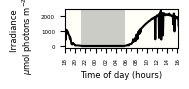

In [9]:
#fig 1 light intensity curve
#import light intensity data from MS2005
lightcurve = pd.read_excel("2005_06_30-07_01_MS_light_data.xlsx")
lightcurve["Datetime"]=pd.to_datetime(lightcurve["Datetime"])
fig, ax =plt.subplots(figsize=(2,1))
ax.axvspan(pd.to_datetime("2005-06-30 18:00"),pd.to_datetime("2005-07-01 18:00"),
                              facecolor="lightyellow", alpha=0.25)
ax.axvspan(pd.to_datetime("2005-06-30 21:10"),pd.to_datetime("2005-07-01 05:41"),
                         facecolor="grey", alpha=0.4)
lightcurve.plot(x="Datetime",y="um", ax=ax, color="black", legend=None)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.set_xlabel("Time of day (hours)", fontsize=6)
ax.set_ylabel("Irradiance \n" + r"$\mu$mol photons m$^{-2}$s$^{-1}$", fontsize=6)
ax.tick_params(axis="both", labelsize=4)
ax.set_xlim(pd.to_datetime("2005-06-30 18:00"),pd.to_datetime("2005-07-01 16:00"))
fig.autofmt_xdate(rotation=90, ha="center")
fig.tight_layout()

In [10]:
fig.savefig("fig1_lightintensity_panel.png")
fig.savefig("fig1_lightintensity_panel.svg")

Table 1 created in Excel

Fig2 + associated supplement

In [11]:
#get the list of relabun >1 in all samples
coregenomelist =list(relabun[(relabun >= 1).all(1)].index)

#list of "rare taxa"
raregenomelist =list(relabun[relabun.median(axis=1) < 1].index)

variablelist = list(relabun[(~(relabun >= 1).all(1))&~(relabun.median(axis=1) < 1)].index)

In [12]:
sorted(coregenomelist)

['Acidobacteriota-sp-001',
 'Armatimonadota-sp-002',
 'Armatimonadota-sp-003',
 'Bacteroidota-sp-001',
 'Bacteroidota-sp-002',
 'Bacteroidota-sp-004',
 'Chloroflexota-sp-001',
 'Chloroflexota-sp-002',
 'Chloroflexota-sp-008',
 'Chloroflexota-sp-009',
 'Cyanobacteria-sp-001',
 'Nitrospirota-sp-001']

In [13]:
sorted(variablelist)

['Acidobacteriota-sp-004',
 'Acidobacteriota-sp-005',
 'Acquificota-sp-001',
 'Armatimonadota-sp-001',
 'Armatimonadota-sp-005',
 'Bacteroidota-sp-003',
 'Bacteroidota-sp-005',
 'Bacteroidota-sp-006',
 'Caldatribacteriota-sp-001',
 'Chloroflexota-sp-003',
 'Chloroflexota-sp-004',
 'Chloroflexota-sp-005',
 'Cyanobacteria-sp-002',
 'Cyanobacteria-sp-003',
 'Deinococcota-sp-001',
 'Deinococcota-sp-002',
 'Desulfobacterota-sp-001',
 'Microgenomates-sp-001',
 'Planctomycetota-sp-007',
 'Proteobacteria-sp-001',
 'Proteobacteria-sp-003',
 'Spirochaetota-sp-001',
 'Spirochaetota-sp-003',
 'Termotogota-sp-001']

In [14]:
sorted(raregenomelist)

['Acidobacteriota-sp-002',
 'Acidobacteriota-sp-003',
 'Acidobacteriota-sp-006',
 'Actinobacteriota-sp-001',
 'Armatimonadota-sp-004',
 'Bacteroidota-sp-007',
 'Bacteroidota-sp-008',
 'Bacteroidota-sp-009',
 'Bacteroidota-sp-010',
 'Bacteroidota-sp-011',
 'Chloroflexota-sp-006',
 'Chloroflexota-sp-007',
 'Cyanobacteria-sp-004',
 'Desulfobacterota-sp-002',
 'Elusimicrobiota-sp-001',
 'Nitrospirota-sp-002',
 'Planctomycetota-sp-001',
 'Planctomycetota-sp-002',
 'Planctomycetota-sp-003',
 'Planctomycetota-sp-004',
 'Planctomycetota-sp-005',
 'Planctomycetota-sp-006',
 'Planctomycetota-sp-008',
 'Planctomycetota-sp-009',
 'Planctomycetota-sp-010',
 'Proteobacteria-sp-002',
 'Proteobacteria-sp-004',
 'Spirochaetota-sp-002',
 'Spirochaetota-sp-004',
 'Spirochaetota-sp-005',
 'Spirochaetota-sp-006',
 'Spirochaetota-sp-007',
 'Thaumarchaeota-sp-001',
 'Verrucomicrobiota-sp-001',
 'Verrucomicrobiota-sp-002']

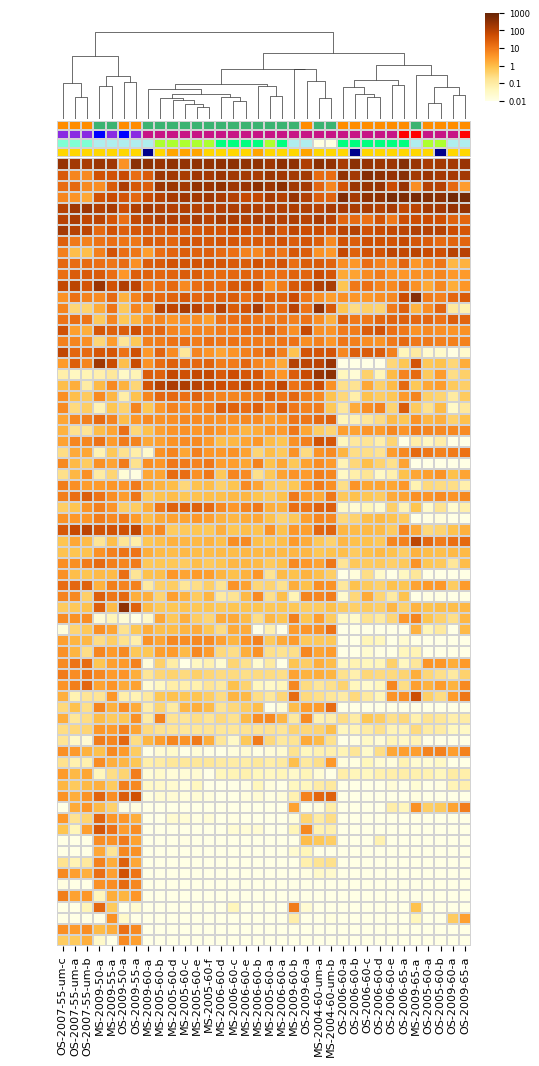

In [15]:
#metagenome panel
plotdata=log10relabun.loc[g_order,altmetaGsampleorder]
g=sns.clustermap(data=plotdata, cmap=sns.color_palette('YlOrBr', as_cmap=True),
              vmax=3, vmin=-2,linewidths=0.3, linecolor='lightgray',
            figsize=(7,11), yticklabels=1, xticklabels=1,
                 row_cluster=False,
                col_colors=[plotdata.columns.map(springcolors),
                            plotdata.columns.map(tempcolors),
                            plotdata.columns.map(yearcolors),
                            plotdata.columns.map(metaG_time_color)],
                 dendrogram_ratio=(0.1),
                 colors_ratio=(0.02,0.01),
                 cbar_pos=(0.7, 0.92, .02, .08))
g.ax_heatmap.set_xticklabels(metadata.set_index("Sample_name").loc[altmetaGsampleorder,:].iloc[g.dendrogram_col.reordered_ind,:]["Table_1_name"], fontsize = 8)
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_ylabel(None)
g.ax_cbar.set_yticks([-2,-1,0,1,2,3], labels=[0.01,0.1,1,10,100,1000],size=6)

In [16]:
#detect phototrophs in metaG lineages
pd.concat([gcanno[gcanno["accession_KOFAM"].isin(["K02689", "K02690", "K08940", "K02703", "K02706", "K08928", "K08929"])],
           gcanno[gcanno["accession_COG_FUNCTION"].isin(["COG5719","COG5716","COG5701","COG5702"])]]).groupby("Consensus Genome Designation").count()

,Gene Cluster,source_annot_COG_FUNCTION,gene_callers_id_COG_FUNCTION,accession_COG_FUNCTION,function_COG_FUNCTION,e_value_COG_FUNCTION,Sample Name_COG_FUNCTION,Bin Number_COG_FUNCTION,Genome Name_COG_FUNCTION,contig_COG_FUNCTION,start_COG_FUNCTION,stop_COG_FUNCTION,direction_COG_FUNCTION,partial_COG_FUNCTION,call_type_COG_FUNCTION,source_genecall_COG_FUNCTION,version_COG_FUNCTION,aa_sequence_COG_FUNCTION,source_annot_COG_CATEGORY,gene_callers_id_COG_CATEGORY,accession_COG_CATEGORY,function_COG_CATEGORY,e_value_COG_CATEGORY,Sample Name_COG_CATEGORY,Bin Number_COG_CATEGORY,Genome Name_COG_CATEGORY,contig_COG_CATEGORY,start_COG_CATEGORY,stop_COG_CATEGORY,direction_COG_CATEGORY,partial_COG_CATEGORY,call_type_COG_CATEGORY,source_genecall_COG_CATEGORY,version_COG_CATEGORY,aa_sequence_COG_CATEGORY,source_annot_COG_PATH,gene_callers_id_COG_PATH,accession_COG_PATH,function_COG_PATH,e_value_COG_PATH,Sample Name_COG_PATH,Bin Number_COG_PATH,Genome Name_COG_PATH,contig_COG_PATH,start_COG_PATH,stop_COG_PATH,direction_COG_PATH,partial_COG_PATH,call_type_COG_PATH,source_genecall_COG_PATH,version_COG_PATH,aa_sequence_COG_PATH,source_annot_KOFAM,gene_callers_id_KOFAM,accession_KOFAM,function_KOFAM,e_value_KOFAM,Sample Name_KOFAM,Bin Number_KOFAM,Genome Name_KOFAM,contig_KOFAM,start_KOFAM,stop_KOFAM,direction_KOFAM,partial_KOFAM,call_type_KOFAM,source_genecall_KOFAM,version_KOFAM,aa_sequence_KOFAM,source_annot_KEGG_CLASS,gene_callers_id_KEGG_CLASS,accession_KEGG_CLASS,function_KEGG_CLASS,e_value_KEGG_CLASS,Sample Name_KEGG_CLASS,Bin Number_KEGG_CLASS,Genome Name_KEGG_CLASS,contig_KEGG_CLASS,start_KEGG_CLASS,stop_KEGG_CLASS,direction_KEGG_CLASS,partial_KEGG_CLASS,call_type_KEGG_CLASS,source_genecall_KEGG_CLASS,version_KEGG_CLASS,aa_sequence_KEGG_CLASS,source_annot_KEGG_MODULE,gene_callers_id_KEGG_MODULE,accession_KEGG_MODULE,function_KEGG_MODULE,e_value_KEGG_MODULE,Sample Name_KEGG_MODULE,Bin Number_KEGG_MODULE,Genome Name_KEGG_MODULE,contig_KEGG_MODULE,start_KEGG_MODULE,stop_KEGG_MODULE,direction_KEGG_MODULE,partial_KEGG_MODULE,call_type_KEGG_MODULE,source_genecall_KEGG_MODULE,version_KEGG_MODULE,aa_sequence_KEGG_MODULE,primary_COG_CATEGORY,primary_COG_PATHWAY
Consensus Genome Designation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Acidobacteriota-sp-001,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
Bacteroidota-sp-001,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Bacteroidota-sp-002,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Chloroflexota-sp-001,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
Chloroflexota-sp-005,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3
Chloroflexota-sp-007,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3
Chloroflexota-sp-008,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2
Chloroflexota-sp-009,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1

In [17]:
#phototroph (["K02689", "K02690", "K08940", "K02703", "K02706", "K08928", "K08929"] or ["COG5719","COG5716","COG5701","COG5702"])
phototrophcolors = {'Acidobacteriota-sp-001':"green", 'Acidobacteriota-sp-002':"white",
       'Acidobacteriota-sp-003':"white", 'Acidobacteriota-sp-004':"white",
       'Acidobacteriota-sp-005':"white", 'Acidobacteriota-sp-006':"white",
       'Acquificota-sp-001':"white", 'Actinobacteriota-sp-001':"white",
       'Armatimonadota-sp-001':"white", 'Armatimonadota-sp-002':"white",
       'Armatimonadota-sp-003':"white", 'Armatimonadota-sp-004':"white",
       'Armatimonadota-sp-005':"white", 'Bacteroidota-sp-001':"green",
                    'Bacteroidota-sp-002':"green",
       'Bacteroidota-sp-003':"white", 'Bacteroidota-sp-004':"white", 
                    'Bacteroidota-sp-005':"white",
       'Bacteroidota-sp-006':"white", 'Bacteroidota-sp-007':"white",
                    'Bacteroidota-sp-008':"white",
       'Bacteroidota-sp-009':"white", 'Bacteroidota-sp-010':"white",
                    'Bacteroidota-sp-011':"white",
       'Caldatribacteriota-sp-001':"white", 'Chloroflexota-sp-001':"green",
       'Chloroflexota-sp-002':"white", 'Chloroflexota-sp-003':"white",
                    'Chloroflexota-sp-004':"white",
       'Chloroflexota-sp-005':"green", 'Chloroflexota-sp-006':"white",
                    'Chloroflexota-sp-007':"green",
       'Chloroflexota-sp-008':"green", 'Chloroflexota-sp-009':"green",
                    'Cyanobacteria-sp-001':"green",
       'Cyanobacteria-sp-002':"green", 'Cyanobacteria-sp-003':"green",
                    'Cyanobacteria-sp-004':"green",
       'Deinococcota-sp-001':"white", 'Deinococcota-sp-002':"white",
                    'Desulfobacterota-sp-001':"white",
       'Desulfobacterota-sp-002':"white", 'Elusimicrobiota-sp-001':"white",
       'Microgenomates-sp-001':"white", 'Nitrospirota-sp-001':"white",
                    'Nitrospirota-sp-002':"white",
       'Planctomycetota-sp-001':"white", 'Planctomycetota-sp-002':"white",
       'Planctomycetota-sp-003':"white", 'Planctomycetota-sp-004':"white",
       'Planctomycetota-sp-005':"white", 'Planctomycetota-sp-006':"white",
       'Planctomycetota-sp-007':"white", 'Planctomycetota-sp-008':"white",
       'Planctomycetota-sp-009':"white", 'Planctomycetota-sp-010':"white",
       'Proteobacteria-sp-001':"white", 'Proteobacteria-sp-002':"white",
       'Proteobacteria-sp-003':"green", 'Proteobacteria-sp-004':"green",
       'Spirochaetota-sp-001':"white", 'Spirochaetota-sp-002':"white",
                    'Spirochaetota-sp-003':"white",
       'Spirochaetota-sp-004':"white", 'Spirochaetota-sp-005':"white", 
                    'Spirochaetota-sp-006':"white",
       'Spirochaetota-sp-007':"white", 'Termotogota-sp-001':"white",
                    'Thaumarchaeota-sp-001':"white",
       'Verrucomicrobiota-sp-001':"white", 'Verrucomicrobiota-sp-002':"white"}



In [18]:
g.savefig("fig2_metaGpanel.png", dpi=300)
g.savefig("fig2_megaGpanel.svg", dpi=300)

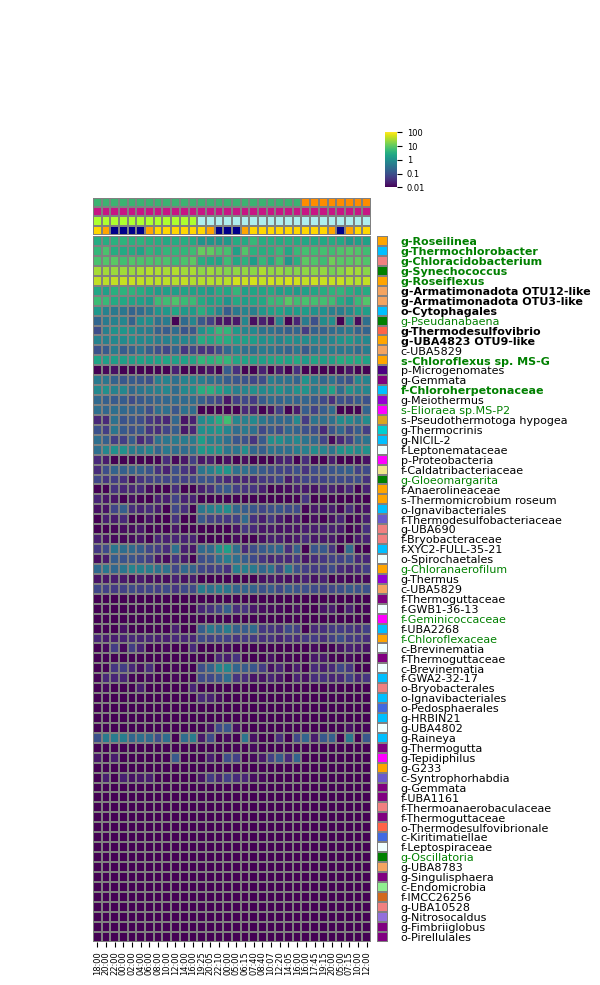

In [19]:
#metatranscriptome panel
plotdata = logcpm.loc[g_order, metaTsampleorder]
g=sns.clustermap(data=plotdata, cmap=sns.color_palette('viridis', as_cmap=True),
              vmax=2, vmin=-2,linewidths=0.2, linecolor='gray',
            figsize=(6,11), yticklabels=1, xticklabels=1,
                 row_cluster=False, col_cluster=False,
                 colors_ratio=(0.02,0.01),
                  cbar_pos=(0.65, 0.825, .02, .05),
                 row_colors=[plotdata.index.map(phylumcolors)],
                col_colors=[plotdata.columns.map(metaTspring_color),
                            plotdata.columns.map(metaT_temp_color),
                           plotdata.columns.map(metaTyear_color),
                            plotdata.columns.map(metaT_col_color)])
g.ax_heatmap.set_xticklabels(ms2005times+ms2009times+os2009times, fontsize = 6)
g.ax_cbar.set_yticks([-2,-1,0,1,2], labels=[0.01,0.1,1,10,100],size=6)
for i, ytick in enumerate(g.ax_heatmap.get_yticklabels()):
    if g_order[i] in coregenomelist:
        ytick.set(weight="bold")
    if phototrophcolors[g_order[i]]=="green":
        ytick.set(color="green")
    #if g_order[i] in onepctgenomes:
    #    ytick.set(style="italic")
       #strictonepct genomes will be annotated in illustration software
g.ax_heatmap.set_yticklabels(g_order_names3, fontsize = 8)
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.tick_params(axis="y", pad=18, right=False)

ax_row_colors = g.ax_row_colors
box = ax_row_colors.get_position()

box_heatmap = g.ax_heatmap.get_position()
ax_row_colors.set_position([box_heatmap.max[0]+0.01, box.y0, box.width*1.5, box.height])

ax_col_colors = g.ax_col_colors
box1 = ax_col_colors.get_position()
ax_col_colors.set_position([box1.x0, box_heatmap.max[1]+.001, box1.width, box1.height])

In [20]:
g.savefig("fig2_metaTpanel.png", dpi=300)
g.savefig("fig2_metaTpanel.svg", dpi=300)

In [21]:
#count phyla with phototrophic annotation
photos =  relabun.copy(deep=True)

In [22]:
photos["phototroph"]=photos.index.map(phototrophcolors)
photos["phylum"]=photos.index.map(phylumcolors)

In [23]:
photos[photos["phototroph"]=="green"].groupby("phylum").count()

,Hotspr20SampleT8,Hotspr20SampleT9,Hotspr2Sampleee2,Hotspr2Sampleme2,Hotspr2Sample148,Hotspr2Sample149,HotsprSampleR4cd,HotsprSampleMS50,HotsprSampleMS55,HotsprSampleMS60,HotsprSampleMS65,HotsprSampleMSe1,HotsprSampleMSe2,HotsprSampleMS13,HotsprSampleMSe3,HotsprSampleMSe4,Hotspr20SampleP4,Hotspr2SamplePe2,Hotspr20Samplet1,Hotspr20Samplem2,HotsprOSTMatCore,HotsprottomLayer,HotsprottomLayer_2,HotsprSamplt10cd,HotsprSampleOS50,HotsprSampleOS55,HotsprSampleOS60,HotsprSampleOS65,HotsprSampleOSM1,HotsprSampleOSM2,HotsprSampleOSM4,HotsprSampOS1260,HotsprSampOS1265,HotsprSampleOSM3,phototroph
phylum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
deepskyblue,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
green,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
lightcoral,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
magenta,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
orange,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [24]:
#sup fig pct read mapping
#data deposited on figshare
alignmentmetaG = pd.read_csv("metaG_coverage_curated_bins.csv", header=0, names=["Sample","pct_aligned","reads_aligned"])
alignmentmetaG=alignmentmetaG.merge(metadata, how="left", left_on="Sample",right_on="Sample_name" )

/tmp/ipykernel_25748/2362340955.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(alignmentmetaG.sort_values("Spring"), x="Spring", y="pct_aligned", palette=["mediumseagreen","darkorange"], ax=ax)
/tmp/ipykernel_25748/2362340955.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Mushroom Spring","Octopus Spring"])


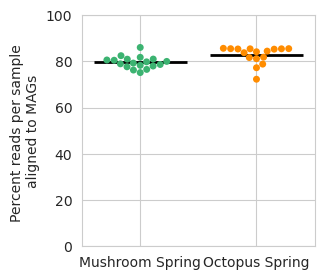

In [25]:
with sns.axes_style("whitegrid"):
    fig, ax=plt.subplots(figsize=(3,3))
    sns.swarmplot(alignmentmetaG.sort_values("Spring"), x="Spring", y="pct_aligned", palette=["mediumseagreen","darkorange"], ax=ax)
    sns.boxplot(alignmentmetaG.sort_values("Spring"), x="Spring", y="pct_aligned",ax=ax,
                showmeans=True, meanline=True, 
                meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False},
                whiskerprops={'visible': False},
               showbox=False, showfliers=False, showcaps=False)
    ax.set_ylim(0,100)
    ax.set_xticklabels(["Mushroom Spring","Octopus Spring"])
    ax.set_ylabel("Percent reads per sample \naligned to MAGs")
    ax.set_xlabel("")
    ax.grid(which="major",axis="both",visible=True)
    fig.savefig("Supplementary_fig_1.png", dpi=300, bbox_inches="tight")
    fig.savefig("Supplementary_fig_1.svg", dpi=300, bbox_inches="tight")

In [26]:
#supplement Shannon diversity + Kruskal-Wallis statistic fig + table
#calculate diversity metrics for lineages/samples in metaG using skbio.diversity
metaGshannon = skbio.diversity.alpha_diversity("shannon",relabun.T, ids=relabun.T.index)
minimalmeta = metadata[metadata["Data_type"]=="metagenome"].loc[:,["Sample_name","Spring","Year","Depth"]]
plotdata =minimalmeta.copy(deep=True).set_index("Sample_name")
plotdata["shannon"]=metaGshannon

#kruskal wallis test all samples springs
print("between springs, all",stats.kruskal(plotdata[plotdata["Spring"]=="MushroomSpring"]["shannon"],plotdata[plotdata["Spring"]=="OctopusSpring"]["shannon"]))

#kruskal wallis test 60C samples springs
print("between springs, 60C",stats.kruskal(plotdata.loc[altmetaGsampleorder60,:][plotdata.loc[altmetaGsampleorder60,:]["Spring"]=="MushroomSpring"]["shannon"],
              plotdata.loc[altmetaGsampleorder60,:][plotdata.loc[altmetaGsampleorder60,:]["Spring"]=="OctopusSpring"]["shannon"]))

between springs, all KruskalResult(statistic=4.285714285714292, pvalue=0.03843393023678172)
between springs, 60C KruskalResult(statistic=9.231884057971016, pvalue=0.002378367930590134)


In [27]:
#export shannon index values
metaGshannon.to_excel("SupplementaryData5.xlsx", index=True)

/tmp/ipykernel_25748/483123334.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Mushroom Spring","Octopus Spring"])


Text(-0.4, 4.3, 'Kruskal-Wallis statistic: 9.232\nP-value: 0.002')

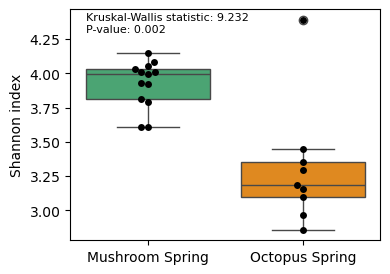

In [28]:
#60C shannon diversity plot for supplment by springs
fig, ax=plt.subplots(figsize=(4,3))

statssprings60=stats.kruskal(plotdata.loc[altmetaGsampleorder60,:][plotdata.loc[altmetaGsampleorder60,:]["Spring"]=="MushroomSpring"]["shannon"],
              plotdata.loc[altmetaGsampleorder60,:][plotdata.loc[altmetaGsampleorder60,:]["Spring"]=="OctopusSpring"]["shannon"])

sns.boxplot(plotdata.loc[altmetaGsampleorder60,:].reset_index(),x="Spring", y="shannon",ax=ax, hue="Spring", palette=["mediumseagreen","darkorange"])
sns.swarmplot(plotdata.loc[altmetaGsampleorder60,:].reset_index(),x="Spring", y="shannon",ax=ax, color="black")
ax.set_ylabel("Shannon index")
ax.set_xlabel("")
ax.set_xticklabels(["Mushroom Spring","Octopus Spring"])
ax.text(-0.4,4.3,"Kruskal-Wallis statistic: "+str(np.round(statssprings60[0],3))+"\nP-value: "+str(np.round(statssprings60[1],3)), size=8)

In [29]:
fig.savefig("Supplementary_fig_2a.png", dpi=300, bbox_inches="tight")
fig.savefig("Supplementary_fig_2a.svg", dpi=300, bbox_inches="tight")

In [30]:
#supplement Bray-Curtis diversity table all samples
braycurtisbetad =  pd.DataFrame(sp.distance.squareform(sp.distance.pdist(X=relabun.T.to_numpy(), metric="braycurtis")), columns=relabun.columns, index=relabun.columns)

In [31]:
braycurtisbetad.to_csv("SupplementaryData6.csv")

Text(1.3, -0.5, 'ANOSIM\nR= 0.769\np-value= 0.001\nPermutations= 999')

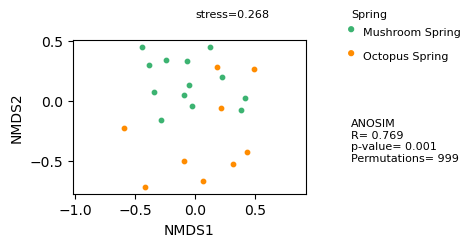

In [32]:
#supplement Bray-Curtis on nMDS plot
#nMDS samples relative abundance using bray curtis 60C
#nMDS
mds = MDS(random_state=0, metric=False, dissimilarity="precomputed", normalized_stress=True)
braycurtis60betad = pd.DataFrame(sp.distance.squareform(sp.distance.pdist(X=relabun.loc[:,altmetaGsampleorder60].T.to_numpy(), metric="braycurtis")), columns=relabun.loc[:,altmetaGsampleorder60].columns, index=relabun.loc[:,altmetaGsampleorder60].columns)
mds_braycurtis60 = mds.fit_transform(braycurtis60betad)
fig, ax = plt.subplots(figsize=(3,2))
ax.axis("equal")
for i in range(0,len(mds_braycurtis60)):
    ax.scatter(mds_braycurtis60[i,0],mds_braycurtis60[i,1], color=springcolors[braycurtis60betad.columns[i]], s=10)
ax.text(x=0,y=0.7,s="stress="+str(np.round(mds.stress_, 3)), size=8)
ax.add_artist(mpl.patches.Circle(xy=(1.3,0.6),radius=0.02, color="mediumseagreen", clip_on=False))
ax.add_artist(mpl.patches.Circle(xy=(1.3,0.4),radius=0.02, color="darkorange", clip_on=False))
ax.text(x=1.4, y=0.55, s="Mushroom Spring", size=8)
ax.text(x=1.4, y=0.35, s="Octopus Spring", size=8)
ax.text(x=1.3, y=0.7, s="Spring", size=8)
ax.set_xlabel("NMDS1")
ax.set_ylabel("NMDS2")


#ANOSIM to test for differences between springs 60C only
anosimresults = skbio.stats.distance.anosim(skbio.diversity.beta_diversity("braycurtis", relabun.loc[:,altmetaGsampleorder60].T, ids=relabun.loc[:,altmetaGsampleorder60].T.index), plotdata.loc[relabun.loc[:,altmetaGsampleorder60].columns,"Spring"],permutations=999)
ax.text(x=1.3, y=-0.5, s="ANOSIM\nR= "+str(np.round(anosimresults["test statistic"],3))+"\np-value= "+str(np.round(anosimresults["p-value"],3))+"\nPermutations= "+str(np.round(anosimresults["number of permutations"])), size=8)

In [33]:
fig.savefig("Supplementary_fig_2b.png", dpi=300, bbox_inches="tight")
fig.savefig("Supplementary_fig_2b.svg", dpi=300, bbox_inches="tight")

In [34]:
#supplement ANCOM results table
#ANCOM differentinal abundance test 60C only and no undermat
springsgroup60 = minimalmeta[minimalmeta["Sample_name"].isin(altmetaGsampleorder60)].loc[:,["Sample_name","Spring"]].set_index("Sample_name").squeeze()
yeargroup60 =  minimalmeta[minimalmeta["Sample_name"].isin(altmetaGsampleorder60)].loc[:,["Sample_name","Year"]].set_index("Sample_name").squeeze()
ancomsprings60 =skbio.stats.composition.ancom(table=relabun.loc[:,altmetaGsampleorder60].T+0.001, grouping=springsgroup60, alpha=0.05, significance_test=stats.f_oneway)

In [35]:
#convert to merge the two ANCOM results for export
ancomsprings60[0].columns=[["Percentile","Percentile"],ancomsprings60[0].columns]

In [36]:
ancomsprings60[0].sort_values(("Percentile","Reject null hypothesis"),ascending=False)

Percentile                       
                                   W Reject null hypothesis
Consensus Genome                                           
Chloroflexota-sp-006              69                   True
Spirochaetota-sp-006              56                   True
Spirochaetota-sp-002              62                   True
Acquificota-sp-001                52                   True
Bacteroidota-sp-005               55                   True
Acidobacteriota-sp-001            14                  False
Planctomycetota-sp-005            23                  False
Desulfobacterota-sp-002           38                  False
Proteobacteria-sp-003              3                  False
Proteobacteria-sp-004             23                  False
Planctomycetota-sp-003            18                  False
Planctomycetota-sp-002            17                  False
Planctomycetota-sp-006            28                  False
Spirochaetota-sp-007              42                  False
Planctomycetota-sp-004            17                  False
Planctomycetota-sp-001             4                  False
Planctomycetota-sp-008            22                  False
Planctomycetota-sp-007            31                  False
Planctomycetota-sp-010            26                  False
Proteobacteria-sp-002             39                  False
Spirochaetota-sp-001               8                  False
Proteobacteria-sp-001             17                  False
Nitrospirota-sp-002               17                  False
Spirochaetota-sp-003              51                  False
Spirochaetota-sp-005              13                  False
Thaumarchaeota-sp-001             10                  False
Desulfobacterota-sp-001           11                  False
Termotogota-sp-001                50                  False
Verrucomicrobiota-sp-001          14                  False
Armatimonadota-sp-001             14                  False
Bacteroidota-sp-003               51                  False
Bacteroidota-sp-010                4                  False
Bacteroidota-sp-011                8                  False
Verrucomicrobiota-sp-002          11                  False
Spirochaetota-sp-004              17                  False
Planctomycetota-sp-009            22                  False
Microgenomates-sp-001             45                  False
Nitrospirota-sp-001               36                  False
Armatimonadota-sp-002             26                  False
Bacteroidota-sp-002               23                  False
Bacteroidota-sp-001               20                  False
Caldatribacteriota-sp-001         42                  False
Bacteroidota-sp-004               22                  False
Bacteroidota-sp-009                7                  False
Bacteroidota-sp-007               46                  False
Armatimonadota-sp-003             34                  False
Acidobacteriota-sp-005            22                  False
Armatimonadota-sp-004             30                  False
Acidobacteriota-sp-003             2                  False
Actinobacteriota-sp-001           21                  False
Acidobacteriota-sp-002            14                  False
Acidobacteriota-sp-004            15                  False
Acidobacteriota-sp-006            22                  False
Chloroflexota-sp-003              44                  False
Chloroflexota-sp-002              36                  False
Chloroflexota-sp-001              34                  False
Chloroflexota-sp-005              11                  False
Chloroflexota-sp-009              25                  False
Chloroflexota-sp-007              24                  False
Chloroflexota-sp-004               7                  False
Chloroflexota-sp-008              25                  False
Cyanobacteria-sp-003              23                  False
Cyanobacteria-sp-004              22                  False
Cyanobacteria-sp-002              45                  False
Cyanob

In [37]:
ancomplot=log10relabun.loc[ancomsprings60[0][ancomsprings60[0][("Percentile","Reject null hypothesis")]==True].index,altmetaGsampleorder60]

/tmp/ipykernel_25748/3836225829.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(g_order_names3)


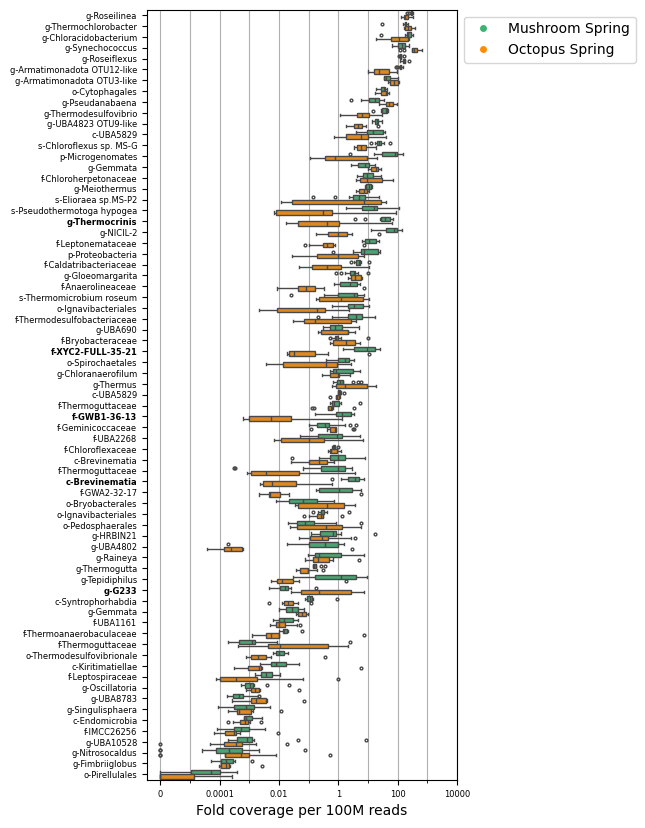

In [38]:
plot60=log10relabun.loc[g_order,altmetaGsampleorder60]
plot60melt=plot60.reset_index().melt(id_vars="Consensus Genome")
plot60melt["spring"]=plot60melt["variable"].map(springcolors)
fig, ax=plt.subplots(figsize=(4,10))
sns.boxplot(data=plot60melt, y="Consensus Genome", x="value", hue="spring",palette=["mediumseagreen", "darkorange"], fliersize=2,ax=ax)
ax.tick_params(labelsize=6)
legend_elements=[Line2D([0], [0], marker='o', color="w",markerfacecolor="mediumseagreen", label="Mushroom Spring"),
                 Line2D([0], [0], marker='o', color="w",markerfacecolor="darkorange", label="Octopus Spring")]
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1))
ax.set_ylabel("")
ax.set_xlabel("Fold coverage per 100M reads")
minor_locator = mpl.ticker.AutoMinorLocator(1)
ax.xaxis.set_minor_locator(minor_locator)
ax.tick_params(axis='y', which='minor', bottom=False)
ax.set_xticks([-6,-4,-2,0,2,4], labels=[0, 0.0001, 0.01,1,100,10000],size=6)
ax.set_xticks([-5,-3,-1,1,3],minor=True)
ax.tick_params(axis='y', which='minor', bottom=False)
ax.grid(axis="x", which="both", visible=True)
ax.set_yticklabels(g_order_names3)
for i, ytick in enumerate(ax.get_yticklabels()):
    if g_order[i] in (ancomplot.index):
        ytick.set(weight="bold")
        
fig.savefig("Supplementary_fig_3.png", dpi=300, bbox_inches="tight")
fig.savefig("Supplementary_fig_3.svg", dpi=300, bbox_inches="tight")

In [39]:
#export ANCOM springs
ancomsprings60[0].merge(ancomsprings60[1], how="left", left_index=True, right_index=True).to_excel("SupplementaryData7.xlsx", merge_cells=True)

In [40]:
#supplement gene expression summary table
genesummary=pd.DataFrame()
genesummary["ORFs"] =gff.groupby("Lineage")["Gene Cluster"].nunique()
genesummary["annotated"]=gcanno.groupby("Consensus Genome Designation", dropna=False).size()
genesummary.index.names=["Lineage"]
genesummary["MS2005_detected"] = ms2005cpmmeta.groupby("Lineage").size()
genesummary["MS2009_detected"] = ms2009cpmmeta.groupby("Lineage").size()
genesummary["OS2009_detected"] = os2009cpmmeta.groupby("Lineage").size()
genesummary["MS2005_highexpress"] = highms2005.groupby("Lineage").size()
genesummary["MS2009_highexpress"] = highms2009.groupby("Lineage").size()
genesummary["OS2009_highexpress"]= highos2009.groupby("Lineage").size()
genesummary["highexpress_all"] = unionhigh.groupby("Lineage").size()
genesummary["genes_COG_CATEGORY"] = gcanno[gcanno["source_annot_COG_CATEGORY"].notna()].rename(columns={"Consensus Genome Designation":"Lineage"}).groupby("Lineage").size()
genesummary["genes_COG_FUNCTION"] = gcanno[gcanno["source_annot_COG_FUNCTION"].notna()].rename(columns={"Consensus Genome Designation":"Lineage"}).groupby("Lineage").size()
genesummary["genes_KOFAM"] = gcanno[gcanno["source_annot_KOFAM"].notna()].rename(columns={"Consensus Genome Designation":"Lineage"}).groupby("Lineage").size()
genesummary["genes_KEGG_MODULE"] = gcanno[gcanno["source_annot_KEGG_MODULE"].notna()].rename(columns={"Consensus Genome Designation":"Lineage"}).groupby("Lineage").size()
genesummary["genes_COG_CATEGORY_highexpress"] = unionhigh[unionhigh["source_annot_COG_CATEGORY"].notna()].groupby("Lineage").size()
genesummary["genes_COG_FUNCTION_highexpress"] = unionhigh[unionhigh["source_annot_COG_FUNCTION"].notna()].groupby("Lineage").size()
genesummary["genes_KOFAM_highexpress"] = unionhigh[unionhigh["source_annot_KOFAM"].notna()].groupby("Lineage").size()
genesummary["genes_KEGG_MODULE_highexpress"] = unionhigh[unionhigh["source_annot_KEGG_MODULE"].notna()].groupby("Lineage").size()
genesummary.fillna(0, inplace=True)
genesummary.to_excel("SupplementaryData10.xlsx")

The pan-genome phylogenetic tree was created in a parallel pipeline

Fig 3 panels

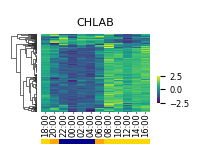

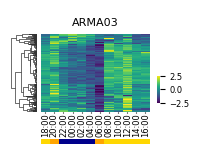

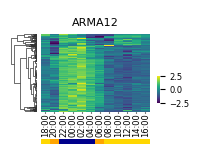

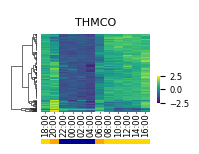

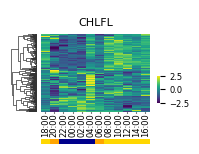

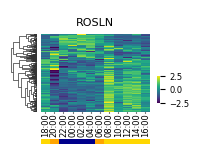

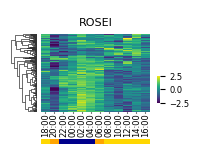

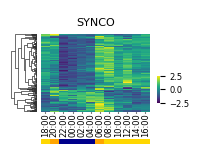

In [41]:
#heatmap panels for part a
#MS2005 top 8 in main text -  final layout made in ppt or inkscape due to the complexity of the axes
#order rows by correlation complete clusters -  downsample each genome to 500 genes
for lineage in strictonepctgenomes:
    lineagewgcna = unionhigh[unionhigh["Lineage"]==lineage].loc[:,["Gene Cluster","ME","MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12"]]
    samplen = int(len(lineagewgcna)*0.25)
   # if samplen > 500:
    samplen=500
    plotdata=np.log2(lineagewgcna.filter(like="Metof")+1).sample(samplen, random_state=42)
    g=sns.clustermap(data=plotdata,col_cluster=False, 
                     metric="correlation", method="complete", cmap="viridis", z_score=0, center=0, vmin=-2.5, vmax=2.5, 
                     yticklabels=False, cbar_pos=(0.95,0.6,0.02,0.1), figsize=(1.7,2.7),col_colors=plotdata.columns.map(metaT_col_color))
    g.ax_heatmap.set_title(strictonepctnames[lineage], fontsize=8)
    #g.ax_heatmap.text(0,0, "n= " +str(samplen),fontsize=6)
    g.ax_heatmap.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
    g.ax_heatmap.tick_params(axis="both", length=1, pad=0)
    g.ax_heatmap.set_xticklabels(ms2005times, fontsize=6)
    g.figure.axes[-1].tick_params(labelsize=6)
    ax_col_colors = g.ax_col_colors
    boxcol = ax_col_colors.get_position()
    box_heatmap = g.ax_heatmap.get_position()
    ax_col_colors.set_position([boxcol.x0, box_heatmap.min[1]-0.12, boxcol.width, boxcol.height*1.5])
    g
    g.savefig(lineage+"_fig3a_panel.png", dpi=300)
    g.savefig(lineage+"_fig3a_panel.svg", dpi=300)

/home/ashelton/miniconda3/envs/metagen3.9biotoolsv2/lib/python3.9/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


Text(92.42550505050504, 1.7, 'Genes with max expression')

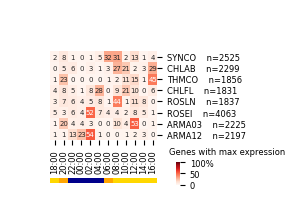

In [42]:
#summary for panel b
serieslist = []
for lineage in strictonepctplotorder:
    lineagewgcna = unionhigh[unionhigh["Lineage"]==lineage].loc[:,["Gene Cluster","ME","MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12"]]
    lineagemelt = lineagewgcna.melt(id_vars="Gene Cluster",value_vars=["MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12"], var_name="sample")

    series = lineagemelt.loc[lineagemelt.groupby("Gene Cluster")["value"].idxmax()].groupby("sample").count()["value"]/(len(lineagewgcna))*100
    series.name=lineage
    serieslist.append(series)
countsummary = pd.concat(serieslist, axis=1).fillna(0).reindex(["MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12"])
#create the genome name + gene num labels
strictlabels = []
strictlabelsdict = {}
for x, y in genesummary[genesummary.index.isin(strictonepctplotorder)]["highexpress_all"].astype(int).items():
    strictlabels.append(strictonepctnames[x]+"   n="+str(y))
    strictlabelsdict[x]=str(y)
strictlabels2=[]
for x in strictonepctplotorder:
    strictlabels2.append(strictonepctnames[x] +"    n="+ strictlabelsdict[x])
plotdata=countsummary.T.loc[strictonepctplotorder,:]
ax=sns.clustermap(plotdata,annot=True, fmt=".0f", vmin=0, vmax=100, 
               cmap="Reds",cbar_kws={"aspect":10, "shrink":0.25},
              annot_kws={"fontsize":5},col_cluster=False, row_cluster=False, figsize=(1.9,1.7),
                 cbar_pos=(1,-0.15,0.02,0.13), col_colors=plotdata.columns.map(metaT_col_color))
ax.ax_heatmap.tick_params(labelsize=6)
ax.ax_heatmap.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax.ax_heatmap.set_xticklabels(ms2005times)
ax.ax_heatmap.set_xlabel(None)
ax.ax_heatmap.set_yticks(np.arange(0.5,8.5,1))
ax.ax_heatmap.set_yticklabels(strictlabels2)
ax_col_colors = ax.ax_col_colors
boxcol = ax_col_colors.get_position()
box_heatmap = ax.ax_heatmap.get_position()
ax_col_colors.set_position([boxcol.x0, box_heatmap.min[1]-0.25, boxcol.width, boxcol.height*1.5])
ax.ax_cbar.set_yticks([0,50,100], labels=["0","50","100%"],size=6)
ax.ax_cbar.set_ylabel("Genes with max expression",size=6, rotation=0, y=1.7, labelpad=10)

In [43]:
ax.savefig("fig3b.png", dpi=300)
ax.savefig("fig3b.svg", dpi=300)

In [44]:
#supplement max expression for all taxa all three time series- highly expressed genes only
serieslist = []
for lineage in set(unionhigh["Lineage"]):
    lineagewgcna = unionhigh[unionhigh["Lineage"]==lineage].loc[:,["Gene Cluster","ME","MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12"]]
    lineagemelt = lineagewgcna.melt(id_vars="Gene Cluster",value_vars=["MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12"], var_name="sample")

    series = lineagemelt.loc[lineagemelt.groupby("Gene Cluster")["value"].idxmax()].groupby("sample").count()["value"]/(len(lineagewgcna))*100
    series.name=lineage
    serieslist.append(series)
countsummary1 = pd.concat(serieslist, axis=1).fillna(0).reindex(["MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12"])
#create the genome name + gene num labels
strictlabels = []
genomeorder = []
for x, y in genesummary[genesummary.index.isin(countsummary1.columns)]["highexpress_all"].astype(int).sort_values(ascending=False).items():
    try:
        strictlabels.append(namesdict3[x]+"    n="+str(y))
        genomeorder.append(x)
    except:
        pass

In [45]:
#supplement max expression for all taxa all three time series- highly expressed genes only
serieslist = []
for lineage in set(unionhigh["Lineage"]):
    lineagewgcna = unionhigh[unionhigh["Lineage"]==lineage].loc[:,["Gene Cluster","ME","MetofsampleR2cd","MetofsampleR3cd","MetofsampleR5cd","MetofsampleR6cd",
                "MetofsampleR7cd","MetofsampleR8cd","MetofsampleR9cd","MetofsamplR10cd",
                "MetofsamplR11cd","MetofsamplR12cd","MetofsamplR13cd","MetofsamplR14cd"]]
    lineagemelt = lineagewgcna.melt(id_vars="Gene Cluster",value_vars=["MetofsampleR2cd","MetofsampleR3cd","MetofsampleR5cd","MetofsampleR6cd",
                "MetofsampleR7cd","MetofsampleR8cd","MetofsampleR9cd","MetofsamplR10cd",
                "MetofsamplR11cd","MetofsamplR12cd","MetofsamplR13cd","MetofsamplR14cd"], var_name="sample")

    series = lineagemelt.loc[lineagemelt.groupby("Gene Cluster")["value"].idxmax()].groupby("sample").count()["value"]/(len(lineagewgcna))*100
    series.name=lineage
    serieslist.append(series)
countsummary2 = pd.concat(serieslist, axis=1).fillna(0).reindex(["MetofsampleR2cd","MetofsampleR3cd","MetofsampleR5cd","MetofsampleR6cd",
                "MetofsampleR7cd","MetofsampleR8cd","MetofsampleR9cd","MetofsamplR10cd",
                "MetofsamplR11cd","MetofsamplR12cd","MetofsamplR13cd","MetofsamplR14cd"])


In [46]:
#supplement max expression for all taxa all three time series- highly expressed genes only
serieslist = []
for lineage in set(unionhigh["Lineage"]):
    lineagewgcna = unionhigh[unionhigh["Lineage"]==lineage].loc[:,["Gene Cluster","ME","Metofsamplet1cd","Metofsamplet2cd", "Metofsamplet4cd","Metofsamplet5cd",
                "Metofsamplet8cd","Metofsamplt11cd", "Metofsamplt13cd", "Metofsamplt14cd"]]
    lineagemelt = lineagewgcna.melt(id_vars="Gene Cluster",value_vars=["Metofsamplet1cd","Metofsamplet2cd", "Metofsamplet4cd","Metofsamplet5cd",
                "Metofsamplet8cd","Metofsamplt11cd", "Metofsamplt13cd", "Metofsamplt14cd"], var_name="sample")

    series = lineagemelt.loc[lineagemelt.groupby("Gene Cluster")["value"].idxmax()].groupby("sample").count()["value"]/(len(lineagewgcna))*100
    series.name=lineage
    serieslist.append(series)
countsummary3 = pd.concat(serieslist, axis=1).fillna(0).reindex(["Metofsamplet1cd","Metofsamplet2cd", "Metofsamplet4cd","Metofsamplet5cd",
                "Metofsamplet8cd","Metofsamplt11cd", "Metofsamplt13cd", "Metofsamplt14cd"])



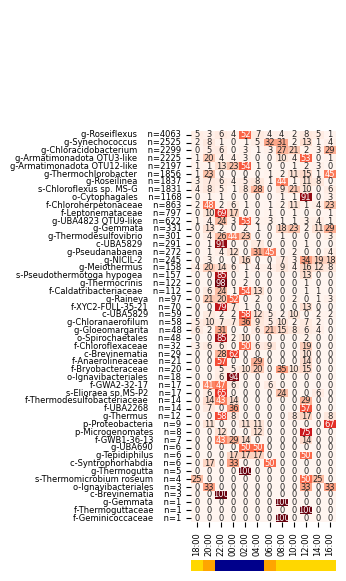

In [47]:
#plot the MS2005 count summary
plotdata = countsummary1.T.loc[genomeorder,:]
ax=sns.clustermap(plotdata,annot=True, fmt=".0f", vmin=0, vmax=100, 
               cmap="Reds",cbar_kws={"aspect":10, "shrink":0.25},
              annot_kws={"fontsize":6},col_cluster=False, row_cluster=False, figsize=(4,7),
                 cbar_pos=None, col_colors=plotdata.columns.map(metaT_col_color))
ax.ax_heatmap.tick_params(labelsize=6)
ax.ax_heatmap.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax.ax_heatmap.set_xticklabels(ms2005times)
ax.ax_heatmap.set_xlabel(None)
ax.ax_heatmap.set_yticks(np.arange(0.5,len(genomeorder)+0.5,1))
ax.ax_heatmap.set_yticklabels(strictlabels)
ax.ax_heatmap.yaxis.tick_left()
ax_col_colors = ax.ax_col_colors
boxcol = ax_col_colors.get_position()
box_heatmap = ax.ax_heatmap.get_position()
ax_col_colors.set_position([boxcol.x0, box_heatmap.min[1]-0.07, boxcol.width, boxcol.height*0.7])
ax.savefig("Supplementary_fig4_MS2005.png", dpi=300)
ax.savefig("Supplementary_fig4_MS2005.svg", dpi=300)

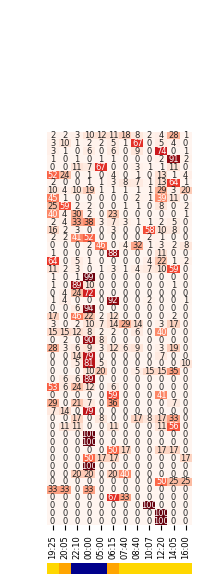

In [48]:
#plot the MS2009 count summary
plotdata = countsummary2.T.loc[genomeorder,:]
ax=sns.clustermap(plotdata,annot=True, fmt=".0f", vmin=0, vmax=100, 
               cmap="Reds",cbar_kws={"aspect":10, "shrink":0.25},
              annot_kws={"fontsize":6},col_cluster=False, row_cluster=False, figsize=(4,7),
                 cbar_pos=None, col_colors=plotdata.columns.map(metaT_col_color))
ax.ax_heatmap.tick_params(labelsize=6)
ax.ax_heatmap.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
ax.ax_heatmap.set_xticklabels(ms2009times)
ax.ax_heatmap.set_xlabel(None)
ax.ax_heatmap.set_yticks([])
ax_col_colors = ax.ax_col_colors
boxcol = ax_col_colors.get_position()
box_heatmap = ax.ax_heatmap.get_position()
ax_col_colors.set_position([boxcol.x0, box_heatmap.min[1]-0.07, boxcol.width, boxcol.height*0.7])
ax.savefig("Supplementary_fig4_MS2009.png", dpi=300)
ax.savefig("Supplementary_fig4_MS2009.svg", dpi=300)

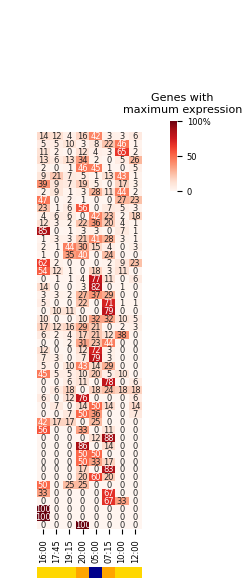

In [49]:
#plot the MS2005 count summary
plotdata = countsummary3.T.loc[genomeorder,:]
ax=sns.clustermap(plotdata,annot=True, fmt=".0f", vmin=0, vmax=100, 
               cmap="Reds",cbar_kws={"aspect":10, "shrink":0.25},
              annot_kws={"fontsize":6},col_cluster=False, row_cluster=False, figsize=(3.5,7),
                 cbar_pos=(0.5,0.72,0.02,0.1), col_colors=plotdata.columns.map(metaT_col_color))
ax.ax_heatmap.tick_params(labelsize=6)
ax.ax_heatmap.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])
ax.ax_heatmap.set_xticklabels(os2009times)
ax.ax_heatmap.set_xlabel(None)
ax.ax_heatmap.set_yticks([])
ax_col_colors = ax.ax_col_colors
boxcol = ax_col_colors.get_position()
box_heatmap = ax.ax_heatmap.get_position()
ax_col_colors.set_position([boxcol.x0, box_heatmap.min[1]-0.07, boxcol.width, boxcol.height*0.7])
ax.ax_cbar.set_yticks([0,50,100], labels=["0","50","100%"],size=6)
ax.ax_cbar.set_ylabel("Genes with\nmaximum expression",size=8, rotation=0, y=1.4, labelpad=-20)
ax.savefig("Supplementary_fig4_OS2009.png", dpi=300)
ax.savefig("Supplementary_fig4_OS2009.svg", dpi=300)

MetaT supplemental tables - created in excel or during R pipeline

Fig 4 + associated supplement

In [50]:
#genes search lists
nitrogenasekegg = ["K02586","K02588","K02591","K00531","K22896","K22897","K22898","K22899","K02592","K02587","K02585"]
nitrogenaseaccessorykegg =["K15790","K02595",
                 "K02593","K02597","K02596","K02594","K22903"]
nitrogentransport = ["K03320"]
photosystem = ["K02689", "K02690", "K08940", "K02703", "K02706", "K08928", "K08929"]
photosystemCOG = ["COG5719","COG5716","COG5701","COG5702"]#alt annotations for main PSI and PSII
rhodopsin = ["K04641", "K04642"]
hydrogenasekegg = ["K00436","K18005","K18006","K18007","K17992","K17993","K17994","K18330","K18331","K18332",
                   "K17997","K17998","K17999","K17993","K17994","K00437","K18008","K05922","K05927",
                   "K00532","K00533","K00534","K06441","K18016","K18017","K18023","K25123",
                   "K00440","K00441","K00443","K13942","K14068","K14069","K14070",
                   "K17995","K17996","K06281","K06282","K23548","K23549","K14126","K14127","K14128"]

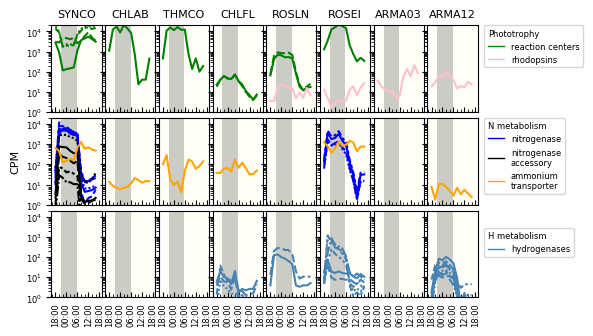

In [51]:
#fig 4 - MS2005
fig, axs = plt.subplots(ncols=8, nrows=3, figsize=(5.5,4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.07,wspace=0.07)
index=0
col =0
plottedlist = []
#photosystems

#photsynthesis and rhodopsin
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=pd.concat([df[(df["accession_KOFAM"].fillna("none").str.contains('|'.join(photosystem)))],
                   df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(photosystemCOG)))]], axis=0).drop_duplicates()
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2005dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="green")
    except:
        pass

    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].set_yticks([1,10,100,1000,10000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    axs[index, col].tick_params(axis="x",which="both",direction="in")
    col+=1
col=0

for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    try:
        p =df[df["function_COG_FUNCTION"].fillna("none").str.contains("rhodopsin")]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col], color="pink")
    except:
        pass
    col+=1
    
    
col=0
index+=1


#nitrogen
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 17:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p = df[df["accession_KOFAM"].fillna("none").str.contains('|'.join(nitrogenasekegg))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2005dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="blue")
        
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].set_yticks([1,10,100,1000,10000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    axs[index, col].tick_params(axis="x",which="both",direction="in")
    col+=1

col=0
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    try:
        p=df[df["accession_KOFAM"].fillna("none").str.contains('|'.join(nitrogenaseaccessorykegg))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2005dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="black")
    except:
        pass
    col+=1
col=0
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    try:
        p=df[df["accession_KOFAM"].fillna("none").str.contains('|'.join(nitrogentransport))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col], color="orange")
    except:
        pass
    col+=1
col=0
index+=1

#hydrogenases
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_KOFAM"].fillna("none").str.contains('|'.join(hydrogenasekegg)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2005dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="steelblue")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].set_yticks([1,10,100,1000,10000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    axs[index, col].tick_params(axis="x",which="both",direction="in")
    col+=1
col=0
index+=1

fig.autofmt_xdate(rotation=90, ha="center")
axs[2,0].set_xlabel("")
axs[2,1].set_xlabel("")
axs[2,2].set_xlabel("")
axs[2,3].set_xlabel("")
axs[2,4].set_xlabel("")
axs[2,5].set_xlabel("")
axs[2,6].set_xlabel("")
axs[2,7].set_xlabel("")
axs[0,0].set_ylabel("")
axs[1,0].set_ylabel("CPM", fontsize=8)
axs[2,0].set_ylabel("")

#titles
axs[0,0].set_title(textwrap.fill("SYNCO", 10),fontsize=8, wrap=True)
axs[0,1].set_title(textwrap.fill("CHLAB", 6),fontsize=8, wrap=True)
axs[0,2].set_title(textwrap.fill("THMCO", 6),fontsize=8, wrap=True)
axs[0,3].set_title(textwrap.fill("CHLFL", 6),fontsize=8, wrap=True)
axs[0,4].set_title(textwrap.fill("ROSLN", 8),fontsize=8, wrap=True)
axs[0,5].set_title(textwrap.fill("ROSEI", 8),fontsize=8, wrap=True)
axs[0,6].set_title(textwrap.fill("ARMA03", 8),fontsize=8, wrap=True)
axs[0,7].set_title(textwrap.fill("ARMA12", 10),fontsize=8, wrap=True)



#legends
axs[0,7].legend([Line2D([0],[0],color="green",lw=1),Line2D([0],[0],color="pink",lw=1)],
                ["reaction centers","rhodopsins"], bbox_to_anchor=(1.05,1.05), title="Phototrophy",alignment="left", prop={'size':6}, title_fontsize=6)
          
axs[1,7].legend([Line2D([0],[0],color="blue",lw=1),Line2D([0],[0],color="black",lw=1),
                Line2D([0],[0],color="orange",lw=1)],
                ["nitrogenase","nitrogenase\naccessory","ammonium\ntransporter"], bbox_to_anchor=(1.05,1.05), title="N metabolism",alignment="left", prop={'size':6}, 
                title_fontsize=6,ncol=1)

axs[2,7].legend([Line2D([0],[0],color="steelblue",lw=1)],
                ["hydrogenases"], bbox_to_anchor=(1.05,0.85), title="H metabolism", alignment="left", prop={'size':6}, title_fontsize=6)


#concatenate the plotted df and save
ms2005selectgenes = pd.concat(plottedlist)

In [52]:
fig.savefig("fig4.png", dpi=300, bbox_inches = "tight")
fig.savefig("fig4.svg", dpi=300, bbox_inches = "tight")

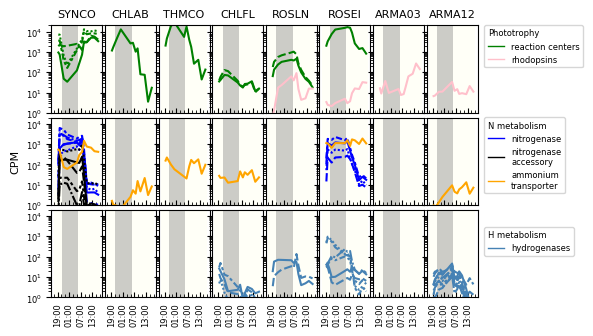

In [53]:
#supplement MS2009
fig, axs = plt.subplots(ncols=8, nrows=3, figsize=(5.5,4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05,wspace=0.05)
index=0
col =0
plottedlist=[]

#photsynthesis and rhodopsin
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 17:00"),pd.to_datetime("2009-07-30 17:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=pd.concat([df[(df["accession_KOFAM"].fillna("none").str.contains('|'.join(photosystem)))],
                   df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(photosystemCOG)))]], axis=0).drop_duplicates()
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2009dt).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="green")
    except:
        pass

    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    axs[index, col].tick_params(axis="x",which="both",direction="in")
    col+=1
col=0

for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    try:
        p=df[df["function_COG_FUNCTION"].fillna("none").str.contains("rhodopsin")]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col], color="pink")
    except:
        pass
    col+=1
    
    
col=0
index+=1
#nitrogen
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 17:00"),pd.to_datetime("2009-07-30 17:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[df["accession_KOFAM"].fillna("none").str.contains('|'.join(nitrogenasekegg))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2009dt).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="blue")
        
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    axs[index, col].tick_params(axis="x",which="both",direction="in")
    col+=1

col=0
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    try:
        p=df[df["accession_KOFAM"].fillna("none").str.contains('|'.join(nitrogenaseaccessorykegg))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2009dt).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="black")
    except:
        pass
    col+=1

col=0
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    try:
        p= df[df["accession_KOFAM"].fillna("none").str.contains('|'.join(nitrogentransport))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col], color="orange")
    except:
        pass
    col+=1
col=0
index+=1
#hydrogenases
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 17:00"),pd.to_datetime("2009-07-30 17:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_KOFAM"].fillna("none").str.contains('|'.join(hydrogenasekegg)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2009dt).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="steelblue")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    axs[index, col].tick_params(axis="x",which="both",direction="in")
    col+=1
col=0
index+=1


fig.autofmt_xdate(rotation=90, ha="center")
#axis labels
axs[2,0].set_xlabel("")
axs[2,1].set_xlabel("")
axs[2,2].set_xlabel("")
axs[2,3].set_xlabel("")
axs[2,4].set_xlabel("")
axs[2,5].set_xlabel("")
axs[2,6].set_xlabel("")
axs[2,7].set_xlabel("")
axs[0,0].set_ylabel("")
axs[1,0].set_ylabel("CPM", fontsize=8)
axs[2,0].set_ylabel("")


#titles
axs[0,0].set_title(textwrap.fill("SYNCO", 10),fontsize=8, wrap=True)
axs[0,1].set_title(textwrap.fill("CHLAB", 6),fontsize=8, wrap=True)
axs[0,2].set_title(textwrap.fill("THMCO", 6),fontsize=8, wrap=True)
axs[0,3].set_title(textwrap.fill("CHLFL", 6),fontsize=8, wrap=True)
axs[0,4].set_title(textwrap.fill("ROSLN", 8),fontsize=8, wrap=True)
axs[0,5].set_title(textwrap.fill("ROSEI", 8),fontsize=8, wrap=True)
axs[0,6].set_title(textwrap.fill("ARMA03", 8),fontsize=8, wrap=True)
axs[0,7].set_title(textwrap.fill("ARMA12", 10),fontsize=8, wrap=True)


axs[1,0].set_ylabel("CPM", fontsize=8)
#legends
axs[0,7].legend([Line2D([0],[0],color="green",lw=1),Line2D([0],[0],color="pink",lw=1)],
                ["reaction centers","rhodopsins"], bbox_to_anchor=(1.05,1.05), title="Phototrophy",alignment="left", prop={'size':6}, title_fontsize=6)
          
axs[1,7].legend([Line2D([0],[0],color="blue",lw=1),Line2D([0],[0],color="black",lw=1),
                Line2D([0],[0],color="orange",lw=1)],
                ["nitrogenase","nitrogenase\naccessory","ammonium\ntransporter"], bbox_to_anchor=(1.05,1.05), title="N metabolism",alignment="left", prop={'size':6}, 
                title_fontsize=6,ncol=1)

axs[2,7].legend([Line2D([0],[0],color="steelblue",lw=1)],
                ["hydrogenases"], bbox_to_anchor=(1.05,0.85), title="H metabolism", alignment="left", prop={'size':6}, title_fontsize=6)


#concatenate the plotted df and save
ms2009selectgenes = pd.concat(plottedlist)

In [54]:
fig.savefig("Supplementary_fig_5a.png", dpi=300, bbox_inches = "tight")
fig.savefig("Supplementary_fig_5a.svg", dpi=300, bbox_inches = "tight")

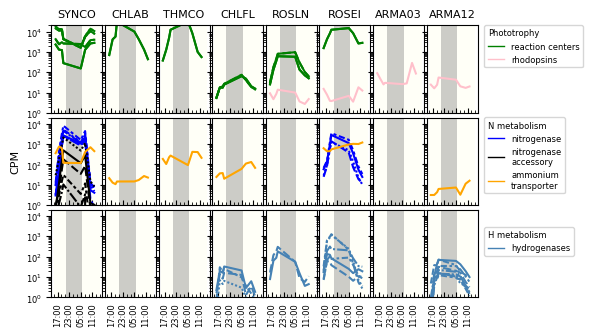

In [55]:
#supplement OS2009
fig, axs = plt.subplots(ncols=8, nrows=3, figsize=(5.5,4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05,wspace=0.05)
index=0
col =0
plottedlist = []

#photosynthesis and rhodopsin
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 15:00"),pd.to_datetime("2009-07-30 15:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=pd.concat([df[(df["accession_KOFAM"].fillna("none").str.contains('|'.join(photosystem)))],
                   df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(photosystemCOG)))]], axis=0).drop_duplicates()
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(os2009dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="green")
    except:
        pass

    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    axs[index, col].tick_params(axis="x",which="both",direction="in")
    col+=1
col=0
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    try:
        p=df[df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(photosystemCOG))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col], color="green")
    except:
        pass
    col+=1
    
col=0
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    try:
        p=df[df["function_COG_FUNCTION"].fillna("none").str.contains("rhodopsin")]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col], color="pink")
    except:
        pass
    col+=1
    
    
col=0
index+=1


#nitrogen
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 15:00"),pd.to_datetime("2009-07-30 15:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[df["accession_KOFAM"].fillna("none").str.contains('|'.join(nitrogenasekegg))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(os2009dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="blue")
        
    except:
        pass
   # axs[index,col].set_title(textwrap.fill(group, 10),fontsize=8)
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    axs[index, col].tick_params(axis="x",which="both",direction="in")
    col+=1

col=0
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    try:
        p=df[df["accession_KOFAM"].fillna("none").str.contains('|'.join(nitrogenaseaccessorykegg))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(os2009dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="black")
    except:
        pass
    col+=1

col=0
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    try:
        p=df[df["accession_KOFAM"].fillna("none").str.contains('|'.join(nitrogentransport))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col], color="orange")
    except:
        pass
    col+=1
col=0
index+=1

#hydrogenases
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 15:00"),pd.to_datetime("2009-07-30 15:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index, col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_KOFAM"].fillna("none").str.contains('|'.join(hydrogenasekegg)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(os2009dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="steelblue")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    axs[index, col].tick_params(axis="x",which="both",direction="in")
    col+=1
col=0
index+=1

fig.autofmt_xdate(rotation=90, ha="center")
#axis labels
axs[2,0].set_xlabel("")
axs[2,1].set_xlabel("")
axs[2,2].set_xlabel("")
axs[2,3].set_xlabel("")
axs[2,4].set_xlabel("")
axs[2,5].set_xlabel("")
axs[2,6].set_xlabel("")
axs[2,7].set_xlabel("")
axs[0,0].set_ylabel("")
axs[1,0].set_ylabel("CPM", fontsize=8)
axs[2,0].set_ylabel("")



#titles
axs[0,0].set_title(textwrap.fill("SYNCO", 10),fontsize=8, wrap=True)
axs[0,1].set_title(textwrap.fill("CHLAB", 6),fontsize=8, wrap=True)
axs[0,2].set_title(textwrap.fill("THMCO", 6),fontsize=8, wrap=True)
axs[0,3].set_title(textwrap.fill("CHLFL", 6),fontsize=8, wrap=True)
axs[0,4].set_title(textwrap.fill("ROSLN", 8),fontsize=8, wrap=True)
axs[0,5].set_title(textwrap.fill("ROSEI", 8),fontsize=8, wrap=True)
axs[0,6].set_title(textwrap.fill("ARMA03", 8),fontsize=8, wrap=True)
axs[0,7].set_title(textwrap.fill("ARMA12", 10),fontsize=8, wrap=True)


axs[1,0].set_ylabel("CPM", fontsize=8)
#legends
axs[0,7].legend([Line2D([0],[0],color="green",lw=1),Line2D([0],[0],color="pink",lw=1)],
                ["reaction centers","rhodopsins"], bbox_to_anchor=(1.05,1.05), title="Phototrophy",alignment="left", prop={'size':6}, title_fontsize=6)
          
axs[1,7].legend([Line2D([0],[0],color="blue",lw=1),Line2D([0],[0],color="black",lw=1),
                Line2D([0],[0],color="orange",lw=1)],
                ["nitrogenase","nitrogenase\naccessory","ammonium\ntransporter"], bbox_to_anchor=(1.05,1.05), title="N metabolism",alignment="left", prop={'size':6}, 
                title_fontsize=6,ncol=1)

axs[2,7].legend([Line2D([0],[0],color="steelblue",lw=1)],
                ["hydrogenases"], bbox_to_anchor=(1.05,0.85), title="H metabolism", alignment="left", prop={'size':6}, title_fontsize=6)


#concatenate the plotted df and save
os2009selectgenes = pd.concat(plottedlist)

In [56]:
fig.savefig("Supplementary_fig_5b.png", dpi=300, bbox_inches = "tight")
fig.savefig("Supplementary_fig_5b.svg", dpi=300, bbox_inches = "tight")

In [57]:
#export list of genes used for plotting w/CPM
ms2005selectgenes[["Lineage", "Gene Cluster","accession_KOFAM","accession_COG_FUNCTION", "MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12"]].merge(ms2009selectgenes[["Lineage","Gene Cluster",
                "MetofsampleR2cd","MetofsampleR3cd","MetofsampleR5cd","MetofsampleR6cd",
                "MetofsampleR7cd","MetofsampleR8cd","MetofsampleR9cd","MetofsamplR10cd",
                "MetofsamplR11cd","MetofsamplR12cd","MetofsamplR13cd","MetofsamplR14cd"]], 
                how="left", left_on=["Lineage","Gene Cluster"],right_on=["Lineage","Gene Cluster"]).merge(os2009selectgenes[["Lineage","Gene Cluster",
                "Metofsamplet1cd","Metofsamplet2cd", "Metofsamplet4cd","Metofsamplet5cd",
                "Metofsamplet8cd","Metofsamplt11cd", "Metofsamplt13cd", "Metofsamplt14cd"]],    
                how="left", left_on=["Lineage","Gene Cluster"],right_on=["Lineage","Gene Cluster"]).drop_duplicates().to_excel("SupplementaryData11.xlsx",na_rep="NaN", index=False)

Fig 5 + associated supplement

In [58]:
#filter to top genomes
wgcnatop =wgcna[wgcna["Lineage"].isin(strictonepctgenomes)]

In [59]:
#supplement expression range table
#magnitude of expression changes in wgcna analysed genes
analyzedgenes = unionhigh.filter(regex="(Metof|Lineage|Gene Cluster)")
analyzedgenes["min"] = analyzedgenes.min(numeric_only=True, axis=1)
analyzedgenes["max"] = analyzedgenes.max(numeric_only=True, axis=1)
analyzedgenes["fold_change"] = analyzedgenes["max"]/(analyzedgenes["min"]+1)
analyzedgenes.groupby("Lineage").agg({"min":["min","max"],"max":["min","max"],"fold_change":["min","max"]}).to_excel("SupplementaryData15.xlsx")

/tmp/ipykernel_25748/1956321499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyzedgenes["min"] = analyzedgenes.min(numeric_only=True, axis=1)
/tmp/ipykernel_25748/1956321499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyzedgenes["max"] = analyzedgenes.max(numeric_only=True, axis=1)
/tmp/ipykernel_25748/1956321499.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [60]:
#calculate the lengths of each genome
totallengths = pd.DataFrame(wgcnatop.groupby(["Lineage"]).count()["GC"]).reset_index().rename(columns={"GC":"len","Lineage":"id"}).rename_axis(index="id")
totallengths["label"] = totallengths["id"]
totallengths = totallengths.T.to_dict()
totallengthslist =[]
for key, value in totallengths.items():
    totallengthslist.append(value)

In [61]:
mecolors1 = {0:"black", 1:"lightcoral", 24:"maroon", 5:"brown", 2:"orangered", 30:"sandybrown", 14:"peru", 11:"rosybrown", 3:"darkorange",
       7:"goldenrod", 32:"khaki", 25:"darkkhaki", 26:"olive", 6:"yellow", 19:"yellowgreen", 4:"lawngreen", 17:"darkseagreen",
       34:"lightgreen", 8:"forestgreen", 13:"aquamarine", 15:"paleturquoise", 28:"teal", 10:"cyan", 36:"deepskyblue", 23:"dodgerblue",
       9:"royalblue", 31:"navy", 29:"mediumslateblue", 21:"blueviolet", 22:"mediumorchid", 27:"violet", 16:"purple", 33:"deeppink",
       12:"pink", 18:"gold", 20:"orchid",35:"red", 36:"mistyrose",37:"sienna",38:"chocolate",39:"firebrick",40:"tomato",41:"saddlebrown",
            42:"moccasin",43:"darkgoldenrod",44:"greenyellow",45:"chartreuse",46:"mediumseagreen",47:"mediumaquamarine",48:"mediumturquoise",49:"aqua",
            50:"cadetblue",51:"powderblue",52:"cornflowerblue",53:"plum", 54:"crimson"}

mecolors = {'ME0':"black", 'ME1':"lightcoral", 'ME24':"maroon", 'ME5':"brown", 'ME2':"orangered", 'ME30':"sandybrown", 'ME14':"peru", 'ME11':"rosybrown", 'ME3':"darkorange",
       'ME7':"goldenrod", 'ME32':"khaki", 'ME25':"darkkhaki", 'ME26':"olive", 'ME6':"yellow", 'ME19':"yellowgreen", 'ME4':"lawngreen", 'ME17':"darkseagreen",
       'ME34':"lightgreen", 'ME8':"forestgreen", 'ME13':"aquamarine", 'ME15':"paleturquoise", 'ME28':"teal", 'ME10':"cyan", 'ME36':"deepskyblue", 'ME23':"dodgerblue",
       'ME9':"royalblue", 'ME31':"navy", 'ME29':"mediumslateblue", 'ME21':"blueviolet", 'ME22':"mediumorchid", 'ME27':"violet", 'ME16':"purple", 'ME33':"deeppink",
       'ME12':"pink", 'ME18':"gold", 'ME20':"orchid", 'ME35':"red", "ME36":"mistyrose","ME37":"sienna","ME38":"chocolate","ME39":"firebrick","ME40":"tomato","ME41":"saddlebrown",
            "ME42":"moccasin","ME43":"darkgoldenrod","ME44":"greenyellow","ME45":"chartreuse","ME46":"mediumseagreen","ME47":"mediumaquamarine","ME48":"mediumturquoise","ME49":"aqua",
            "ME50":"cadetblue","ME51":"powderblue","ME52":"cornflowerblue","ME53":"plum","ME54":"crimson"}
metextorder = ['ME0','ME1', "ME2","ME3","ME4","ME5","ME6","ME7","ME8","ME9","ME10","ME11","ME12",
               "ME13","ME14","ME15","ME16","ME17","ME18","ME19","ME20","ME21","ME22","ME23","ME24",
               "ME25","ME26","ME27","ME28","ME29","ME30","ME31","ME32","ME33","ME34","ME35","ME36",
               "ME37","ME38","ME39","ME40","ME41","ME42","ME43","ME44","ME45","ME46","ME47","ME48",
               "ME49","ME50","ME51","ME52","ME53","ME54"]

In [62]:
#convert lengths to coordinates in ME order
mecount = pd.DataFrame(wgcnatop.groupby(["Lineage","module_num"]).count()["GC"]).sort_values(["Lineage","GC"],ascending=False)

mestartlist= []
for group, df in mecount.groupby("Lineage"):
    for i, v in enumerate(df.iterrows()):
        if i == 0:
            start = 0
            end = df.iloc[i,:].squeeze()-1 #start at same index plus len of ME  -1 
        else:
            start = end +1 #previous end plus 1
            end= df.iloc[i,:].squeeze() -1 + start #start at same index plus len of ME  -1 
        color = mecolors1[v[0][1]]
        mestartlist.append({"block_id":group, "module_num":v[0][1],"start":start,"end":end, "color":color})
        #create me text labels at midpoint of each ME
#skip ME with size =< 250
mestartdf = pd.DataFrame(mestartlist)
textlist = []
for genome, df in mestartdf.groupby("block_id"):
    for module, df2 in df.groupby("module_num"):
        length = df2["end"].squeeze()-df2["start"].squeeze()
        if length > 250:
            position = length/2 + df2["start"].squeeze()
            textlist.append({"block_id":genome,"position": position, "value":"ME"+str(module)})
#get the ME in order we want for plotting as int
meorder= [i for i in range(1,54)]
meorder.append(0)

In [63]:
#pct of genes in lineage analyzed in each me
((wgcnatop[wgcnatop["Lineage"].isin(strictonepctgenomes)].groupby(["Lineage","ME"]).count()["GeneCluster"])/(wgcnatop[wgcnatop["Lineage"].isin(strictonepctgenomes)].groupby(["Lineage"]).count()["GeneCluster"])*100).reset_index().sort_values(["Lineage","GeneCluster"], ascending=False)

,Lineage,ME,GeneCluster
267,Cyanobacteria-sp-001,ME7,37.227723
245,Cyanobacteria-sp-001,ME1,22.099010
252,Cyanobacteria-sp-001,ME19,11.801980
254,Cyanobacteria-sp-001,ME22,8.079208
258,Cyanobacteria-sp-001,ME3,4.554455
...,...,...,...
23,Acidobacteriota-sp-001,ME40,0.086994
5,Acidobacteriota-sp-001,ME14,0.043497
19,Acidobacteriota-sp-001,ME35,0.043497
21,Acidobacteriota-sp-001,ME37,0.043497


In [64]:
#number of taxa per cluster
wgcna.groupby(["ME"]).nunique()["Lineage"].sort_values(ascending=False)

ME
ME2     40
ME9     31
ME0     22
ME4     21
ME1     21
ME3     21
ME5     20
ME17    19
ME8     18
ME13    16
ME15    16
ME7     16
ME6     16
ME26    15
ME24    15
ME11    13
ME28    13
ME25    12
ME27    12
ME36    11
ME40    11
ME35    11
ME14    11
ME10    10
ME22    10
ME12    10
ME19     9
ME38     8
ME42     8
ME51     8
ME20     8
ME34     8
ME32     8
ME30     7
ME23     7
ME46     7
ME54     7
ME37     6
ME21     6
ME16     6
ME41     6
ME44     6
ME18     6
ME53     6
ME29     6
ME52     5
ME33     5
ME47     5
ME39     5
ME31     5
ME49     4
ME48     4
ME50     3
ME45     3
ME43     3
Name: Lineage, dtype: int64

In [65]:
#number of taxa in highly expressed genes
len(wgcna.groupby("Lineage").groups)

50

In [66]:
#what number of clusters have one taxa making up a maority?
modulelineagepct=((wgcna.groupby(["Lineage","ME"]).count()["GeneCluster"])/(wgcna.groupby(["ME"]).count()["GeneCluster"])*100).reset_index().sort_values(["ME","GeneCluster"], ascending=False)
modulelineagepct[(modulelineagepct["GeneCluster"]>90)&(modulelineagepct["ME"]!="ME0")].sort_values("ME")

,Lineage,ME,GeneCluster
582,Spirochaetota-sp-003,ME11,92.640693
230,Chloroflexota-sp-001,ME12,95.967742
132,Bacteroidota-sp-001,ME14,95.164076
67,Armatimonadota-sp-002,ME16,93.846154
440,Cyanobacteria-sp-001,ME19,94.603175
236,Chloroflexota-sp-001,ME20,96.013289
398,Chloroflexota-sp-009,ME21,96.043165
12,Acidobacteriota-sp-001,ME23,91.584158
103,Armatimonadota-sp-003,ME29,94.267516
408,Chloroflexota-sp-009,ME31,90.977444


In [67]:
len(modulelineagepct[(modulelineagepct["GeneCluster"]>50)&(modulelineagepct["ME"]!="ME0")].sort_values("ME"))

47

/tmp/ipykernel_25748/2592327800.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g[i].set_xticklabels([str(strictonepctnames[lineage])+"  k="+str(len(wgcnatop[wgcnatop["Lineage"]==lineage].groupby("ME").groups))],ma="right")
/tmp/ipykernel_25748/2592327800.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g[i].set_xticklabels([str(strictonepctnames[lineage])+"  k="+str(len(wgcnatop[wgcnatop["Lineage"]==lineage].groupby("ME").groups))],ma="right")
/tmp/ipykernel_25748/2592327800.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g[i].set_xticklabels([str(strictonepctnames[lineage])+"  k="+str(len(wgcnatop[wgcnatop["Lineage"]==lineage].groupby("ME").groups))],ma="right")
/tmp/ipykernel_25748/2592327800.py:12: UserWarning: set_tickl

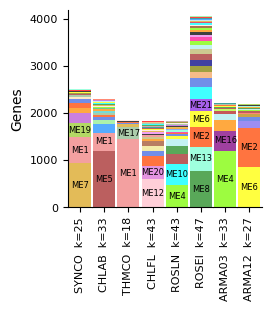

In [68]:
#fig 4a supplement - raw counts
#ME > 250labeled
fig, g = plt.subplots(ncols=8,figsize=(2.5,2.5))
fig.subplots_adjust(top=.9, wspace=0)
i=0
for lineage in strictonepctplotorder:
    lineageorder = wgcnatop[wgcnatop["Lineage"]==lineage].groupby("module_num").count()["GC"].sort_values().index.to_list()
    sns.histplot(data=wgcnatop[wgcnatop["Lineage"]==lineage], x="Lineage", hue="module_num",stat="count", multiple="stack", palette=mecolors1, shrink=0.8,
            hue_order=lineageorder, edgecolor=None, legend=None, ax=g[i])
    g[i].tick_params(axis="x", rotation=90, labelsize=8)
    g[i].tick_params(axis="y", labelsize=8)
    g[i].set_xticklabels([str(strictonepctnames[lineage])+"  k="+str(len(wgcnatop[wgcnatop["Lineage"]==lineage].groupby("ME").groups))],ma="right")
    g[i].set_ylabel("Genes")
    g[i].set_xlabel(None)
    g[i].set_ylim(0,4200)
    g[i].spines["top"].set_visible(False)
    g[i].spines["right"].set_visible(False)

    for j,container in enumerate(g[i].containers):
        labels = ["ME"+str(lineageorder[len(lineageorder)-1-j]) if v > 250 else "" for v in container.datavalues]
        g[i].bar_label(container, labels=labels, label_type="center", fontsize=6)
    if i > 0:
        g[i].set_ylabel(None)
        g[i].set_yticklabels([])
        g[i].set_yticks([])
        g[i].spines["top"].set_visible(False)
        g[i].spines["left"].set_visible(False)
        g[i].spines["right"].set_visible(False)
    i+=1


In [69]:
fig.savefig("Supplementary_fig_6.png", dpi=300, bbox_inches = "tight")
fig.savefig("Supplementary_fig_6.svg", dpi=300, bbox_inches = "tight")

/tmp/ipykernel_25748/1972047419.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g[i].set_xticklabels([str(strictonepctnames[lineage])+"\n(n="+str(len(wgcnatop[wgcnatop["Lineage"]==lineage]))+")"], ma="left")
/tmp/ipykernel_25748/1972047419.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g[i].set_xticklabels([str(strictonepctnames[lineage])+"\n(n="+str(len(wgcnatop[wgcnatop["Lineage"]==lineage]))+")"], ma="left")
/tmp/ipykernel_25748/1972047419.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g[i].set_xticklabels([str(strictonepctnames[lineage])+"\n(n="+str(len(wgcnatop[wgcnatop["Lineage"]==lineage]))+")"], ma="left")
/tmp/ipykernel_25748/1972047419.py:11: UserWarning: set_ticklabels() should only be used with a fixed number 

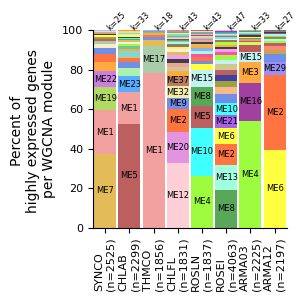

In [70]:
#fig 4a proportional stacked bars
fig, g = plt.subplots(ncols=8,figsize=(2.5,2.5))
fig.subplots_adjust(top=.9, wspace=0)
i=0
for lineage in strictonepctplotorder:
    lineageorder = wgcnatop[wgcnatop["Lineage"]==lineage].groupby("module_num").count()["GC"].sort_values().index.to_list()
    sns.histplot(data=wgcnatop[wgcnatop["Lineage"]==lineage], x="Lineage", hue="module_num",stat="percent", multiple="stack", palette=mecolors1, shrink=0.8,
            hue_order=lineageorder, edgecolor=None, legend=None, ax=g[i])
    g[i].tick_params(axis="x", rotation=90, labelsize=8)
    g[i].tick_params(axis="y", labelsize=8)
    g[i].set_xticklabels([str(strictonepctnames[lineage])+"\n(n="+str(len(wgcnatop[wgcnatop["Lineage"]==lineage]))+")"], ma="left")
    g[i].text(0,100,"k="+str(len(wgcnatop[wgcnatop["Lineage"]==lineage].groupby("ME").groups)), rotation=45, fontsize=6)
    g[i].set_ylabel("Percent of \nhighly expressed genes \nper WGCNA module", size=10)
    g[i].set_xlabel(None)
    g[i].set_ylim(0,100)
    g[i].spines["top"].set_visible(False)
    g[i].spines["right"].set_visible(False)
    for j,container in enumerate(g[i].containers):
        labels = ["ME"+str(lineageorder[len(lineageorder)-1-j]) if v > 5 else "" for v in container.datavalues]
        g[i].bar_label(container, labels=labels, label_type="center", fontsize=6)
    if i > 0:
        g[i].set_ylabel(None)
        g[i].set_yticklabels([])
        g[i].set_yticks([])
        g[i].spines["top"].set_visible(False)
        g[i].spines["left"].set_visible(False)
        g[i].spines["right"].set_visible(False)
    i+=1


In [71]:
fig.savefig("fig5a.png", dpi=300)
fig.savefig("fig5a.svg", dpi=300)

[Text(0.5, 0, 'ME40'),
 Text(1.5, 0, 'ME17'),
 Text(2.5, 0, 'ME14'),
 Text(3.5, 0, 'ME35'),
 Text(4.5, 0, 'ME0'),
 Text(5.5, 0, 'ME25'),
 Text(6.5, 0, 'ME27'),
 Text(7.5, 0, 'ME41'),
 Text(8.5, 0, 'ME49'),
 Text(9.5, 0, 'ME28'),
 Text(10.5, 0, 'ME9'),
 Text(11.5, 0, 'ME2'),
 Text(12.5, 0, 'ME11'),
 Text(13.5, 0, 'ME47'),
 Text(14.5, 0, 'ME50'),
 Text(15.5, 0, 'ME37'),
 Text(16.5, 0, 'ME38'),
 Text(17.5, 0, 'ME24'),
 Text(18.5, 0, 'ME18'),
 Text(19.5, 0, 'ME34'),
 Text(20.5, 0, 'ME48'),
 Text(21.5, 0, 'ME22'),
 Text(22.5, 0, 'ME13'),
 Text(23.5, 0, 'ME21'),
 Text(24.5, 0, 'ME45'),
 Text(25.5, 0, 'ME26'),
 Text(26.5, 0, 'ME31'),
 Text(27.5, 0, 'ME29'),
 Text(28.5, 0, 'ME43'),
 Text(29.5, 0, 'ME8'),
 Text(30.5, 0, 'ME15'),
 Text(31.5, 0, 'ME44'),
 Text(32.5, 0, 'ME53'),
 Text(33.5, 0, 'ME6'),
 Text(34.5, 0, 'ME54'),
 Text(35.5, 0, 'ME30'),
 Text(36.5, 0, 'ME10'),
 Text(37.5, 0, 'ME33'),
 Text(38.5, 0, 'ME52'),
 Text(39.5, 0, 'ME16'),
 Text(40.5, 0, 'ME4'),
 Text(41.5, 0, 'ME39'),
 Text(42

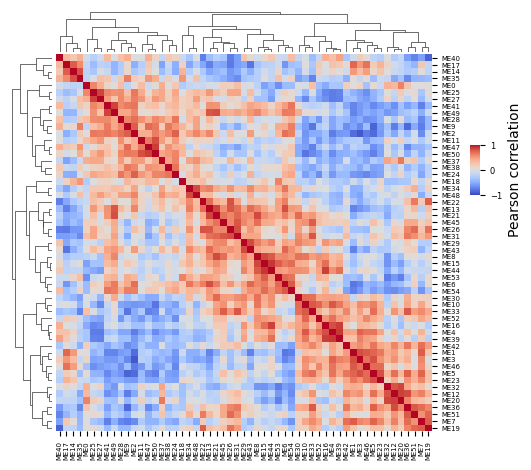

In [72]:
# eigengenes
#concatentate the eigengenes for all 3 time series
concateigengenes=pd.concat([eigengenesms2005,eigengenesms2009,eigengenesos2009]).set_index("sample").filter(like="ME")
eigengenespearson = concateigengenes.corr(method="pearson")
distmatrix = 1-eigengenespearson
linkage = hc.linkage(sp.distance.squareform(distmatrix), method="complete")
ax=sns.clustermap(eigengenespearson, vmin=-1, vmax=1,
               cmap="coolwarm",cbar_kws={"aspect":10, "shrink":0.25, "label":"Pearson correlation"},
              annot_kws={"fontsize":6}, figsize=(5,5), 
                 xticklabels=True, yticklabels=True,row_linkage=linkage, col_linkage=linkage,
                 cbar_pos=(0.95,0.6,0.02,0.1), dendrogram_ratio=0.1)
ax.tick_params(labelsize=8)
ax.figure.axes[-1].tick_params(labelsize=6)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), fontsize = 5)
ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(), fontsize = 5)

In [73]:
#export eigengenedata
concateigengenes.T.sort_index().to_csv("SupplementaryData13.csv", index=True)

In [74]:
ax.savefig("Supplementary_fig_7.png", dpi=300)
ax.savefig("Supplementary_fig_7.svg", dpi=300)

In [75]:
#export eigengene correlation as sup table
eigengenespearson.reindex(metextorder)[metextorder].to_csv("SupplementaryData14.csv")

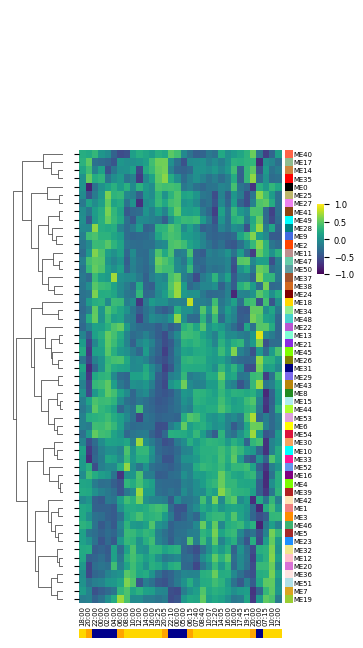

In [76]:
#fig 4b
plotdata=pd.concat([eigengenesms2005,eigengenesms2009,eigengenesos2009]).set_index("sample").filter(like="ME").T
fig4bcol_colors = {"MSt1":"gold","MSt2":"orange", "MSt3":"darkblue","MSt4":"darkblue","MSt5":"darkblue","MSt6":"darkblue","MSt7":"orange",
                   "MSt8":"gold","MSt9":"gold","MSt11":"gold","MSt12":"gold","MSP12":"gold","t1cd":"gold","t2cd":"gold","t4cd":"gold",
                   "t5cd":"orange","t8cd":"darkblue","t11cd":"gold","t13cd":"gold","t14cd":"gold","R2cd":"gold","R3cd":"orange",
                   "R5cd":"darkblue","R6cd":"darkblue","R7cd":"darkblue","R8cd":"orange","R9cd":"gold","R10cd":"gold","R11cd":"gold",
                   "R12cd":"gold","R13cd":"gold","R14cd":"gold"}
g=sns.clustermap(data=plotdata,
                 col_cluster=False, row_linkage=linkage, cmap="viridis", cbar_pos=(0.92,0.6,0.02,0.1),
                 vmin=-1, vmax=1,xticklabels=True, yticklabels=True, col_colors=plotdata.columns.map(fig4bcol_colors),row_colors=pd.Series(mecolors), figsize=(3.5,7))
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize = 5)
g.ax_heatmap.set_xticklabels(ms2005times+ms2009times+os2009times, fontsize = 5)
g.ax_heatmap.tick_params(axis="x",bottom=False, pad=-2)
g.ax_heatmap.tick_params(axis="y",right=False, left=True,pad=5)
g.ax_heatmap.set_xlabel(None)
g.figure.axes[-1].tick_params(labelsize=6)
ax_row_colors = g.ax_row_colors
box = ax_row_colors.get_position()
box_heatmap = g.ax_heatmap.get_position()
ax_row_colors.set_position([box_heatmap.max[0]+.01, box.y0, box.width, box.height])
ax_row_colors.tick_params(bottom=False)
ax_col_colors = g.ax_col_colors
boxcol = ax_col_colors.get_position()
ax_col_colors.set_position([boxcol.x0, box_heatmap.min[1]-0.05, boxcol.width, boxcol.height*0.5])

In [77]:
g.savefig("fig5b.png", dpi=300)
g.savefig("fig5b.svg", dpi=300)

[None]

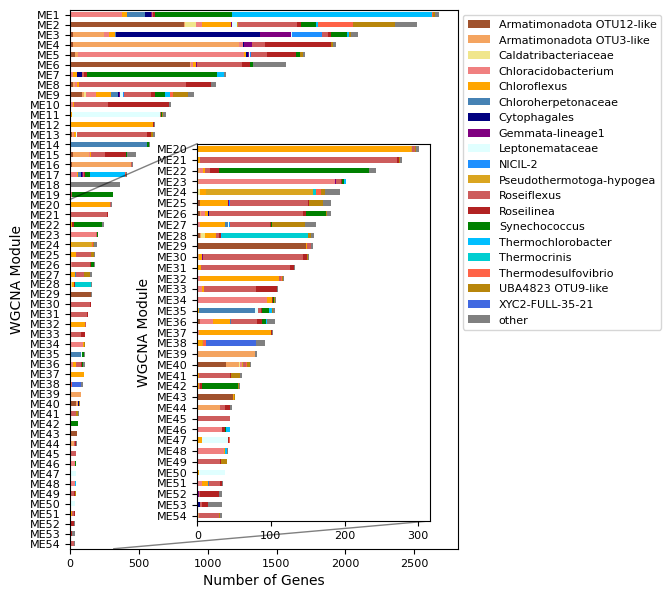

In [78]:
#supplement WGCNA modules bar plot by taxa
unionhighgroups=unionhigh.copy(deep=True)
melist = ["ME1","ME2","ME3","ME4", "ME5","ME6", "ME7","ME8","ME9","ME10","ME11","ME12","ME13","ME14","ME15","ME16","ME17","ME18",
         "ME19","ME20","ME21","ME22","ME23","ME24","ME25","ME26","ME27","ME28","ME29","ME30","ME31","ME32","ME33","ME34","ME35","ME36",
         "ME37","ME38","ME39","ME40","ME41","ME42","ME43","ME44","ME45","ME46","ME47","ME48","ME49","ME50","ME51","ME52","ME53","ME54"]


supwgcnataxacolors= {"Acidobacteriota-sp-001":"lightcoral","Acquificota-sp-001":"darkturquoise",
                "Armatimonadota-sp-002":"sandybrown","Armatimonadota-sp-003":"sienna","Bacteroidota-sp-001":"steelblue",
                "Bacteroidota-sp-002":"deepskyblue","Bacteroidota-sp-003":"dodgerblue",
                "Bacteroidota-sp-004":"navy","Bacteroidota-sp-005":"royalblue","Caldatribacteriota-sp-001":"khaki",
                "Chloroflexota-sp-001":"orange","Chloroflexota-sp-002":"darkgoldenrod",
                "Chloroflexota-sp-008":"firebrick","Chloroflexota-sp-009":"indianred","Cyanobacteria-sp-001":"green",
                 "Nitrospirota-sp-001":"tomato","Planctomycetota-sp-007":"purple",
                "Spirochaetota-sp-003":"lightcyan","Termotogota-sp-001":"goldenrod", "other":"grey"}


unionhighgroups =unionhighgroups.merge(pd.Series(namesdict2,name="newnames"), how="left", left_on="Lineage", right_index=True)

unionhighgroups["onepct"] = np.where(unionhighgroups["Lineage"].isin(onepctgenomes), unionhighgroups["newnames"], "other")
unionhighgroups["top_lineage"] = np.where(unionhighgroups["Lineage"].isin(strictonepctgenomes), unionhighgroups["newnames"], "other")
unionhighgroups["onepctL"] = np.where(unionhighgroups["Lineage"].isin(onepctgenomes), unionhighgroups["Lineage"], "other")
unionhighgroups["top_lineageL"] = np.where(unionhighgroups["Lineage"].isin(strictonepctgenomes), unionhighgroups["Lineage"], "other")
unionhighgroups["colorsonepct"] = unionhighgroups["onepctL"].map(supwgcnataxacolors)
colorssupwgcna = dict(zip(unionhighgroups.onepct, unionhighgroups.colorsonepct))

fig,ax=plt.subplots(figsize=(5,7))
axinset = inset_axes(ax, loc=4, borderpad=2, height="70%",width="60%")
unionhighgroups.groupby(["ME","onepct"]).count()["Gene Cluster"].unstack().loc[list(reversed(melist))].plot(kind="barh",stacked=True, ax=ax, color=colorssupwgcna)
ax.set_xlabel("Number of Genes")
ax.set_ylabel("WGCNA Module")
ax.legend(bbox_to_anchor=(1,1), prop={"size":8})
ax.tick_params(labelsize=8)
unionhighgroups.groupby(["ME","onepct"]).count()["Gene Cluster"].unstack().loc[list(reversed(melist))[:35]].plot(kind="barh",stacked=True, ax=axinset, legend=False, color=colorssupwgcna)
axinset.tick_params(labelsize=8)
axinset.set_ylabel("WGCNA Module")
zbox, zlines =ax.indicate_inset_zoom(axinset, edgecolor="black")
zbox.set(visible=False)
zlines[2].set(visible=True)
zlines[1].set(visible=True)

In [79]:
fig.savefig("Supplementary_fig_8.png", dpi=300, bbox_inches="tight")
fig.savefig("Supplementary_fig_8.svg", dpi=300, bbox_inches="tight")

In [80]:
textcolorsme = {"ME40":"blueviolet","ME17":"blueviolet","ME14":"blueviolet", "ME35":"blueviolet","ME0":"dimgrey", "ME25":"blueviolet","ME27":"blueviolet", "ME41":"blueviolet","ME49":"blueviolet","ME28":"blueviolet",
             "ME9":"blueviolet","ME2":"blueviolet","ME11":"blueviolet","ME47":"blueviolet", "ME50":"blueviolet","ME37":"blueviolet","ME38":"blueviolet", "ME24":"blueviolet","ME18":"dimgrey","ME34":"dimgrey",
             "ME48":"dimgrey","ME22":"mediumblue","ME13":"mediumblue","ME21":"mediumblue","ME45":"mediumblue","ME26":"mediumblue","ME31":"mediumblue","ME29":"dimgrey","ME43":"dimgrey","ME8":"dimgrey",
             "ME15":"dimgrey","ME44":"dimgrey","ME53":"dimgrey","ME6":"dimgrey","ME54":"dimgrey","ME30":"darkgoldenrod","ME10":"darkgoldenrod","ME33":"darkgoldenrod","ME52":"darkgoldenrod", "ME16":"darkgoldenrod",
             "ME4":"darkgoldenrod","ME39":"darkgoldenrod","ME42":"darkgoldenrod","ME1":"darkgoldenrod","ME3":"darkgoldenrod","ME46":"darkgoldenrod","ME5":"darkgoldenrod","ME23":"darkgoldenrod","ME32":"darkgoldenrod","ME12":"darkgoldenrod",
             "ME20":"darkgoldenrod","ME36":"darkgoldenrod", "ME51":"darkgoldenrod", "ME7":"darkgoldenrod", "ME19":"darkgoldenrod"}

ordertocolor ={0:"blueviolet",1:"blueviolet",2:"blueviolet", 3:"blueviolet",4:"dimgrey", 5:"blueviolet",6:"blueviolet", 7:"blueviolet",8:"blueviolet",9:"blueviolet",
             10:"blueviolet",11:"blueviolet",12:"blueviolet",13:"blueviolet", 14:"blueviolet",15:"blueviolet",16:"blueviolet", 17:"blueviolet",18:"dimgrey",19:"dimgrey",
             20:"dimgrey",21:"mediumblue",22:"mediumblue",23:"mediumblue",24:"mediumblue",25:"mediumblue",26:"mediumblue",27:"dimgrey",28:"dimgrey",29:"dimgrey",
             30:"dimgrey",31:"dimgrey",32:"dimgrey",33:"dimgrey",34:"dimgrey",35:"darkgoldenrod",36:"darkgoldenrod",37:"darkgoldenrod",38:"darkgoldenrod", 39:"darkgoldenrod",
             40:"darkgoldenrod",41:"darkgoldenrod",42:"darkgoldenrod",43:"darkgoldenrod",44:"darkgoldenrod",45:"darkgoldenrod",46:"darkgoldenrod",47:"darkgoldenrod",48:"darkgoldenrod",49:"darkgoldenrod",
             50:"darkgoldenrod",51:"darkgoldenrod", 52:"darkgoldenrod", 53:"darkgoldenrod", 54:"darkgoldenrod"}

medescription = {"ME40":"evening/night","ME17":"evening/night","ME14":"evening/night", "ME35":"evening/night","ME0":"variable", "ME25":"evening/night","ME27":"evening/night", "ME41":"evening/night","ME49":"evening/night","ME28":"evening/night",
             "ME9":"evening/night","ME2":"evening/night","ME11":"evening/night","ME47":"evening/night", "ME50":"evening/night","ME37":"evening/night","ME38":"evening/night", "ME24":"evening/night","ME18":"variable","ME34":"variable",
             "ME48":"variable","ME22":"night/morning","ME13":"night/morning","ME21":"night/morning","ME45":"night/morning","ME26":"night/morning","ME31":"night/morning","ME29":"variable","ME43":"variable","ME8":"variable",
             "ME15":"variable","ME44":"variable","ME53":"variable","ME6":"variable","ME54":"variable","ME30":"morning/day","ME10":"morning/day","ME33":"morning/day","ME52":"morning/day", "ME16":"morning/day",
             "ME4":"morning/day","ME39":"morning/day","ME42":"morning/day","ME1":"morning/day","ME3":"morning/day","ME46":"morning/day","ME5":"morning/day","ME23":"morning/day","ME32":"morning/day","ME12":"morning/day",
             "ME20":"morning/day","ME36":"morning/day", "ME51":"morning/day", "ME7":"morning/day", "ME19":"morning/day"}

In [81]:
#fig 5c info for table
fig5c = ((wgcnatop[wgcnatop["Lineage"].isin(strictonepctgenomes)].groupby(["Lineage","ME"]).count()["GeneCluster"])/(wgcnatop[wgcnatop["Lineage"].isin(strictonepctgenomes)].groupby(["Lineage"]).count()["GeneCluster"])*100).reset_index().sort_values(["Lineage","GeneCluster"], ascending=False)
fig5c["Peak Time"]=fig5c["ME"].map(medescription)
fig5c["Taxa"]=fig5c["Lineage"].map(strictonepctnames)
fig5conepct = fig5c[(fig5c["Lineage"].isin(strictonepctgenomes))&(fig5c["GeneCluster"]>5)].sort_values(["Taxa","ME"]).groupby(["Taxa","Peak Time"]).agg({"ME": lambda x:", ".join(x)})

In [82]:
fig5conepct

ME
Taxa   Peak Time                      
ARMA03 morning/day      ME16, ME3, ME4
       variable                   ME15
ARMA12 evening/night               ME2
       variable              ME29, ME6
CHLAB  morning/day      ME1, ME23, ME5
CHLFL  evening/night    ME2, ME37, ME9
       morning/day    ME12, ME20, ME32
ROSEI  evening/night               ME2
       morning/day                ME10
       night/morning        ME13, ME21
       variable               ME6, ME8
ROSLN  morning/day      ME10, ME4, ME5
       variable              ME15, ME8
SYNCO  morning/day      ME1, ME19, ME7
       night/morning              ME22
THMCO  evening/night              ME17
       morning/day                 ME1

supplement table for WGCNA assignments was generated in R pipeline

Fig 6 + associated supplement

In [83]:
totalgenes = wgcna.groupby("Lineage").count()["GC"].reset_index()

In [84]:
#function for ORA analysis
#define function for enrichment factor and p value
#use metascape + https://pnnl-comp-mass-spec.github.io/proteomics-data-analysis-tutorial/ora.html 
def enrich(n,k,N,M):
    """n = genes observed in category, k= genes in category, N=total genes with annotation, M=total genes with annotation observed
    this is defined by metascape, scipy.stats uses different notation"""
    try:
        enrichfactor = (n*N)/(k*M)
        pvalue = 1 - (stats.hypergeom.cdf(n-1,N, k, M))#cdf of hypergeometric.
        #for ref hypergeom.cdf(observed in group, total, group total, observed/chosen at random, location=0)
        return(enrichfactor, pvalue, n,k,N,M)
    except:
        return(np.nan, np.nan, n,k,N,M)


In [85]:
#enrichment cog category in ME per lineage

#COG categories to use
COGcatlist = list(string.ascii_uppercase)

#loop through each lineage and each category
enrichdict = {}
for lineage, df in unionhighgroups[unionhighgroups["ME"].notna()].groupby("Lineage"):
    for ME in metextorder:
        for category in COGcatlist:
            N = len(unionhighgroups[(unionhighgroups["Lineage"]==lineage)&(unionhighgroups["primary_COG_CATEGORY"].notna())]) #genes in genome
            k = len(unionhighgroups[(unionhighgroups["Lineage"]==lineage)&(unionhighgroups["primary_COG_CATEGORY"]==category)]) #cog in genome
            M = len(df[(df["primary_COG_CATEGORY"].notna())&(df["ME"]==ME)]) #ME in lineage
            n = len(df[(df["primary_COG_CATEGORY"]==category)&(df["ME"]==ME)]) #COG category in ME in lineage
            enrichdict[(lineage,ME, category)]=enrich(n,k,N,M)
cogmelineage = pd.DataFrame(enrichdict, index=["enrich_factor","p-value","n","k","N","M"]).transpose().reset_index().rename(columns={"level_0":"Lineage","level_1":"ME", "level_2":"primary_COG_CATEGORY"})
#run a fdr_bh correction on the p values to account for multiple testing
dflist =[]
for group, df in cogmelineage.dropna().groupby(["ME","Lineage"]):
    df["q-value_significant"],df["q-value"],c,a=sm.stats.multipletests(df["p-value"],method="fdr_bh",is_sorted=False)
    dflist.append(df)
modcogmelineage = pd.concat(dflist)
modcogmelineagev2 = pd.merge(cogmelineage, modcogmelineage, how="left")

In [86]:
fig5border = {"ME40":0,"ME17":1,"ME14":2, "ME35":3,"ME0":4, "ME25":5,"ME27":6, "ME41":7,"ME49":8,"ME28":9,
             "ME9":10,"ME2":11,"ME11":12,"ME47":13, "ME50":14,"ME37":15,"ME38":16, "ME24":17,"ME18":18,"ME34":19,
             "ME48":20,"ME22":21,"ME13":22,"ME21":23,"ME45":24,"ME26":25,"ME31":26,"ME29":27,"ME43":28,"ME8":29,
             "ME15":30,"ME44":31,"ME53":32,"ME6":33,"ME54":34,"ME30":35,"ME10":36,"ME33":37,"ME52":38, "ME16":39,
             "ME4":40,"ME39":41,"ME42":42,"ME1":43,"ME3":44,"ME46":45,"ME5":46,"ME23":47,"ME32":48,"ME12":49,
             "ME20":50,"ME36":51, "ME51":52, "ME7":53, "ME19":54}


modcogmelineagev2replot = modcogmelineagev2
modcogmelineagev2replot["order"] = modcogmelineagev2replot["ME"].map(fig5border)
qvaluecolor={True:"black",False:"white"}
def colorssig(data):
    cols=[]
    for d in data:
        if d==True:
            cols.append(mcolors.to_rgba("black"))
        else:
            cols.append(mcolors.to_rgba("white"))
    return cols

/tmp/ipykernel_25748/1534334355.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plotdata=modcogmelineagev2replot[modcogmelineagev2replot["Lineage"]==lineage].fillna(False)
/tmp/ipykernel_25748/1534334355.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mes["order"]=mes["ME"].map(fig5border)
/tmp/ipykernel_25748/1534334355.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future be

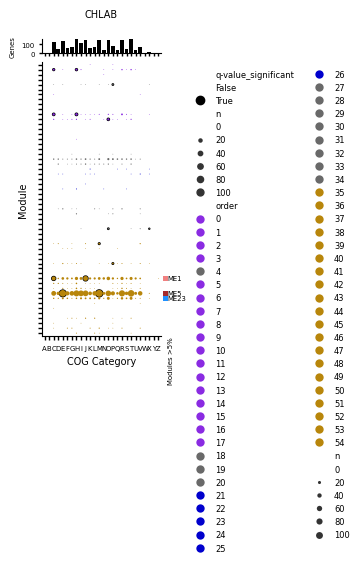

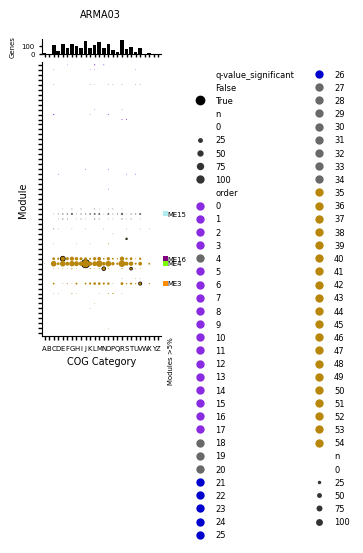

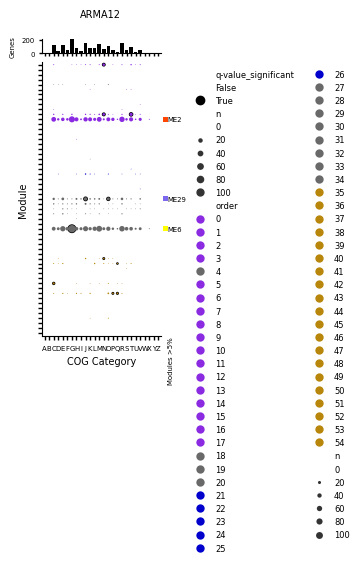

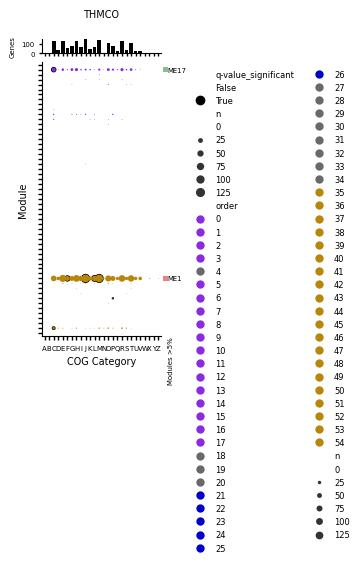

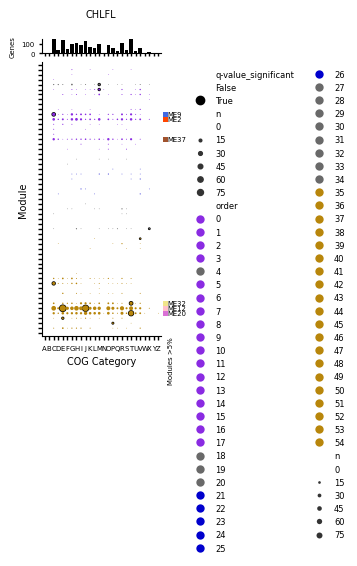

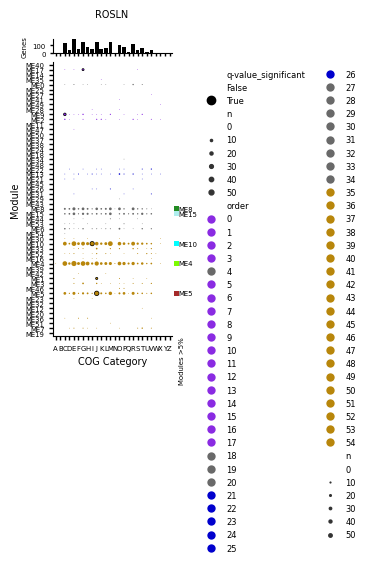

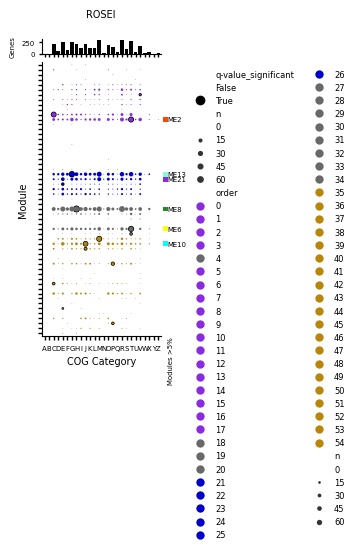

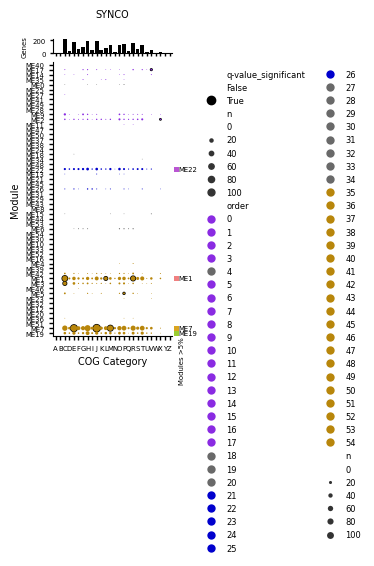

In [87]:
#fig 6 panels
for lineage in strictonepctgenomes:
    plotdata=modcogmelineagev2replot[modcogmelineagev2replot["Lineage"]==lineage].fillna(False)
    g = sns.JointGrid(plotdata,x="primary_COG_CATEGORY",y="order",
                      marginal_ticks=True,ratio=12, space=0.6, hue="order")
    #plot the outline only around data that the q-value was signficant
    sns.scatterplot(data=plotdata,x="primary_COG_CATEGORY",y="order",
                    hue="q-value_significant", palette=["none","black"],
                    edgecolor="face",
                    linewidth=1,
                    size="n", sizes=(0,1000), size_norm=(0,totalgenes[totalgenes["Lineage"]=="Chloroflexota-sp-009"]["GC"].squeeze()), ax=g.ax_joint)
    #plot the data with color relating to the WGCNA module categories
    sns.scatterplot(data=plotdata,x="primary_COG_CATEGORY",y="order",
                    hue="order",palette=ordertocolor,
                    edgecolor="none",
                    linewidth=0,
                    size="n", sizes=(0,1000), size_norm=(0,totalgenes[totalgenes["Lineage"]=="Chloroflexota-sp-009"]["GC"].squeeze()),ax=g.ax_joint)
    #plot the number of genes per COG category
    sns.barplot(data=modcogmelineagev2replot[modcogmelineagev2replot["Lineage"]==lineage].fillna(0).groupby("primary_COG_CATEGORY").sum()["n"].reset_index(),
                x="primary_COG_CATEGORY", y="n",ax=g.ax_marg_x, color="black")

    #clean up the formatting
    g.ax_joint.legend(bbox_to_anchor=(1.2,1), fontsize=6,frameon=False, ncol=2)
    g.ax_joint.set_ylim(-0.5,54.5)
    g.ax_joint.invert_yaxis()
    g.ax_joint.set_yticks(range(0,55,1))

    #for easier combining in inkscape
    if (lineage == "Cyanobacteria-sp-001") or (lineage == "Chloroflexota-sp-008"):
        g.ax_joint.set_yticklabels(plotdata[["order","ME"]].drop_duplicates().sort_values("order")["ME"].to_list(), size=1)
    else:
        g.ax_joint.set_yticklabels([])
        
    g.ax_marg_x.tick_params(labelsize=5, length=2, width=1)
    g.ax_joint.tick_params(labelsize=5, width=1, length=3)
    g.ax_joint.set_xlabel("COG Category", size=7)
    g.ax_joint.set_ylabel("Module", size=7)
    g.ax_marg_x.set_ylabel("Genes", size=5)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(strictonepctnames[lineage], size=7)
    g.fig.set_figwidth(1.5)
    g.fig.set_figheight(3.7)
    #hide the y marginal
    g.ax_marg_y.remove()

    #add text for me >5% if genome
    g.ax_joint.text(x=27, y=64, s="Modules >5%", size=5, rotation=90)
    mes = fig5c[(fig5c["Lineage"]==lineage)&(fig5c["GeneCluster"]>5)]
    mes["order"]=mes["ME"].map(fig5border)
    for i, row in mes.iterrows():
        g.ax_joint.text(x=27, y=row["order"],s=row["ME"], size=5, va="center")
        g.ax_joint.add_patch(Rectangle(xy=(26,row["order"]-0.5),width=1, height=1, facecolor=mecolors[row["ME"]], clip_on=False))
    
    g.savefig(lineage+"_fig6panel.png", dpi=300)
    g.savefig(lineage+"_fig6panel.svg", dpi=300)

In [88]:
#supplement table for ORA results
#rename columns
modcogmelineagev2.rename(columns={"primary_COG_CATEGORY":"COG Category","enrich_factor":"Enrichment factor",
                                "n":"Genes in COG category in ME","k":"Genes in COG category",
                                "N":"Total genes in lineage with COG", "M":"Genes in ME"}, inplace=True)
#export sup table
modcogmelineagev2.to_excel("SupplementaryData16.xlsx", na_rep="NaN", index=False) #export total to supplement

Fig 7 + associated supplement

In [89]:
#gene lists
heatshockcog = ["COG0459","COG0234","COG1734","COG0443","COG0484","COG0576","COG0071"]
groel = ["COG0459"]
groes= ["COG0234"]
dnakjgrpe = ["COG0443"]
smallhsp = ["COG0071"]

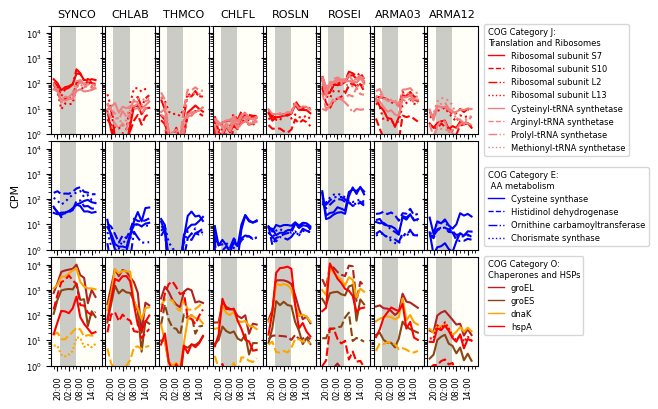

In [90]:
#fig 7 - MS2005
fig, axs = plt.subplots(ncols=8, nrows=3, figsize=(5.5,5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.07,wspace=0.07)
col =0
index=0
plottedlist = []
#category J
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0049"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="red", style="-")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0051"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="red", style="--")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0090"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="red", style="-.")

        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0102"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="red", style=":")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    
    col+=1
col=0

for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0215"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style="-")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0016"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style="--")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0442"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style="-.")

        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0143"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style=":")
    except:
        pass
    col+=1
col=0
index+=1

#AA synthesis (cat E)
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0031"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style="-")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0141"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style="--")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0078"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style="-.")

        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0082"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2005dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style=":")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    
    col+=1
col=0

index+=1


#hsps (cat O)
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(groel)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2005dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="firebrick")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    
    col+=1
col=0
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(groes)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2005dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="saddlebrown")
    except:
        pass
    col+=1
col=0
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(dnakjgrpe)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2005dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="orange")
    except:
        pass
    col+=1
col=0
for group in strictonepctplotorder:
    df = ms2005cpmmeta[ms2005cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(smallhsp)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2005dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="red")
    except:
        pass
    col+=1
col=0

fig.autofmt_xdate(rotation=90, ha="center")

#axis labels
axs[2,0].set_xlabel("")
axs[2,1].set_xlabel("")
axs[2,2].set_xlabel("")
axs[2,3].set_xlabel("")
axs[2,4].set_xlabel("")
axs[2,5].set_xlabel("")
axs[2,6].set_xlabel("")
axs[2,7].set_xlabel("")
axs[0,0].set_ylabel("")
axs[1,0].set_ylabel("CPM", fontsize=8)
axs[2,0].set_ylabel("")




#titles
axs[0,0].set_title(textwrap.fill("SYNCO", 10),fontsize=8, wrap=True)
axs[0,1].set_title(textwrap.fill("CHLAB", 6),fontsize=8, wrap=True)
axs[0,2].set_title(textwrap.fill("THMCO", 6),fontsize=8, wrap=True)
axs[0,3].set_title(textwrap.fill("CHLFL", 6),fontsize=8, wrap=True)
axs[0,4].set_title(textwrap.fill("ROSLN", 8),fontsize=8, wrap=True)
axs[0,5].set_title(textwrap.fill("ROSEI", 8),fontsize=8, wrap=True)
axs[0,6].set_title(textwrap.fill("ARMA03", 8),fontsize=8, wrap=True)
axs[0,7].set_title(textwrap.fill("ARMA12", 10),fontsize=8, wrap=True)


axs[1,0].set_ylabel("CPM", fontsize=8)
#legends
axs[0,7].legend([Line2D([0],[0],color="red",lw=1, linestyle="-"),
                 Line2D([0],[0],color="red",lw=1, linestyle="--"),
                 Line2D([0],[0],color="red",lw=1, linestyle="-."),
                 Line2D([0],[0],color="red",lw=1, linestyle=":"),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle="-"),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle="--"),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle="-."),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle=":"),
                 ],
                ["Ribosomal subunit S7",
                 "Ribosomal subunit S10",
                 "Ribosomal subunit L2",
                 "Ribosomal subunit L13",
                 "Cysteinyl-tRNA synthetase",
                "Arginyl-tRNA synthetase",
                 "Prolyl-tRNA synthetase",
                 "Methionyl-tRNA synthetase"
                ], bbox_to_anchor=(1.05,1.05), title="COG Category J:\nTranslation and Ribosomes", alignment="left", prop={'size':6}, title_fontsize=6)
axs[1,7].legend([ Line2D([0],[0],color="blue",lw=1, linestyle="-"),
                 Line2D([0],[0],color="blue",lw=1, linestyle="--"),
                 Line2D([0],[0],color="blue",lw=1, linestyle="-."),
                 Line2D([0],[0],color="blue",lw=1, linestyle=":")],
                ["Cysteine synthase",
                "Histidinol dehydrogenase",
                "Ornithine carbamoyltransferase",
                "Chorismate synthase"], 
                bbox_to_anchor=(1.05,0.8), title="COG Category E:\n AA metabolism", alignment="left", prop={'size':6}, title_fontsize=6)
axs[2,7].legend([Line2D([0],[0],color="firebrick",lw=1),Line2D([0],[0],color="saddlebrown",lw=1),Line2D([0],[0],color="orange",lw=1),Line2D([0],[0],color="red",lw=1)],
                ["groEL","groES","dnaK", "hspA"], bbox_to_anchor=(1.05,1.05), title="COG Category O:\nChaperones and HSPs", alignment="left", prop={'size':6}, title_fontsize=6)

#concatenate the plotted df and save
ms2005selectgenes = pd.concat(plottedlist)

In [91]:
fig.savefig("fig7.png", dpi=300, bbox_inches = "tight")
fig.savefig("fig7.svg", dpi=300, bbox_inches = "tight")

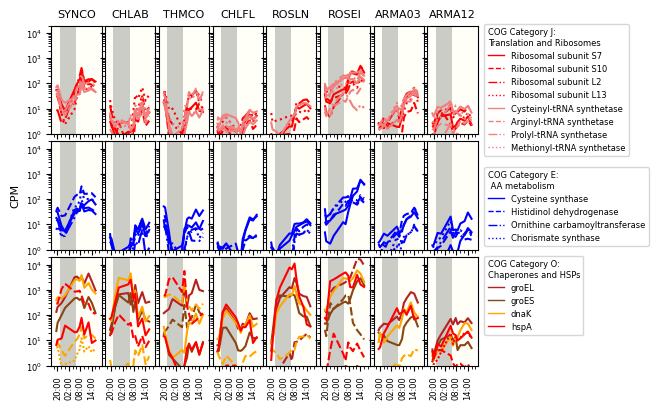

In [92]:
#supplement MS2009
fig, axs = plt.subplots(ncols=8, nrows=3, figsize=(5.5,5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.07,wspace=0.07)
col =0
index=0
plottedlist = []
#category J
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0049"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="red", style="-")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0051"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="red", style="--")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0090"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="red", style="-.")

        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0102"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="red", style=":")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    
    col+=1
col=0

for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0215"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style="-")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0016"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style="--")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0442"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style="-.")

        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0143"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style=":")
    except:
        pass
    col+=1
col=0
index+=1

#AA synthesis (cat E)
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0031"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style="-")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0141"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style="--")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0078"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style="-.")

        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0082"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(ms2009dt).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style=":")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    
    col+=1
col=0

index+=1


#hsps (cat O)
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(groel)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2009dt).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="firebrick")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    
    col+=1
col=0
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(groes)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2009dt).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="saddlebrown")
    except:
        pass
    col+=1
col=0
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(dnakjgrpe)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2009dt).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="orange")
    except:
        pass
    col+=1
col=0
for group in strictonepctplotorder:
    df = ms2009cpmmeta[ms2009cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(smallhsp)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(ms2009dt).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="red")
    except:
        pass
    col+=1
col=0

fig.autofmt_xdate(rotation=90, ha="center")

#axis labels
axs[2,0].set_xlabel("")
axs[2,1].set_xlabel("")
axs[2,2].set_xlabel("")
axs[2,3].set_xlabel("")
axs[2,4].set_xlabel("")
axs[2,5].set_xlabel("")
axs[2,6].set_xlabel("")
axs[2,7].set_xlabel("")
axs[0,0].set_ylabel("")
axs[1,0].set_ylabel("CPM", fontsize=8)
axs[2,0].set_ylabel("")




#titles
axs[0,0].set_title(textwrap.fill("SYNCO", 10),fontsize=8, wrap=True)
axs[0,1].set_title(textwrap.fill("CHLAB", 6),fontsize=8, wrap=True)
axs[0,2].set_title(textwrap.fill("THMCO", 6),fontsize=8, wrap=True)
axs[0,3].set_title(textwrap.fill("CHLFL", 6),fontsize=8, wrap=True)
axs[0,4].set_title(textwrap.fill("ROSLN", 8),fontsize=8, wrap=True)
axs[0,5].set_title(textwrap.fill("ROSEI", 8),fontsize=8, wrap=True)
axs[0,6].set_title(textwrap.fill("ARMA03", 8),fontsize=8, wrap=True)
axs[0,7].set_title(textwrap.fill("ARMA12", 10),fontsize=8, wrap=True)


axs[1,0].set_ylabel("CPM", fontsize=8)
#legends
axs[0,7].legend([Line2D([0],[0],color="red",lw=1, linestyle="-"),
                 Line2D([0],[0],color="red",lw=1, linestyle="--"),
                 Line2D([0],[0],color="red",lw=1, linestyle="-."),
                 Line2D([0],[0],color="red",lw=1, linestyle=":"),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle="-"),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle="--"),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle="-."),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle=":"),
                 ],
                ["Ribosomal subunit S7",
                 "Ribosomal subunit S10",
                 "Ribosomal subunit L2",
                 "Ribosomal subunit L13",
                 "Cysteinyl-tRNA synthetase",
                "Arginyl-tRNA synthetase",
                 "Prolyl-tRNA synthetase",
                 "Methionyl-tRNA synthetase"
                ], bbox_to_anchor=(1.05,1.05), title="COG Category J:\nTranslation and Ribosomes", alignment="left", prop={'size':6}, title_fontsize=6)
axs[1,7].legend([ Line2D([0],[0],color="blue",lw=1, linestyle="-"),
                 Line2D([0],[0],color="blue",lw=1, linestyle="--"),
                 Line2D([0],[0],color="blue",lw=1, linestyle="-."),
                 Line2D([0],[0],color="blue",lw=1, linestyle=":")],
                ["Cysteine synthase",
                "Histidinol dehydrogenase",
                "Ornithine carbamoyltransferase",
                "Chorismate synthase"], 
                bbox_to_anchor=(1.05,0.8), title="COG Category E:\n AA metabolism", alignment="left", prop={'size':6}, title_fontsize=6)
axs[2,7].legend([Line2D([0],[0],color="firebrick",lw=1),Line2D([0],[0],color="saddlebrown",lw=1),Line2D([0],[0],color="orange",lw=1),Line2D([0],[0],color="red",lw=1)],
                ["groEL","groES","dnaK", "hspA"], bbox_to_anchor=(1.05,1.05), title="COG Category O:\nChaperones and HSPs", alignment="left", prop={'size':6}, title_fontsize=6)

#concatenate the plotted df and save
ms2009selectgenes = pd.concat(plottedlist)

In [93]:
fig.savefig("Supplementary_fig_9a.png", dpi=300, bbox_inches = "tight")
fig.savefig("Supplementary_fig_9a.svg", dpi=300, bbox_inches = "tight")

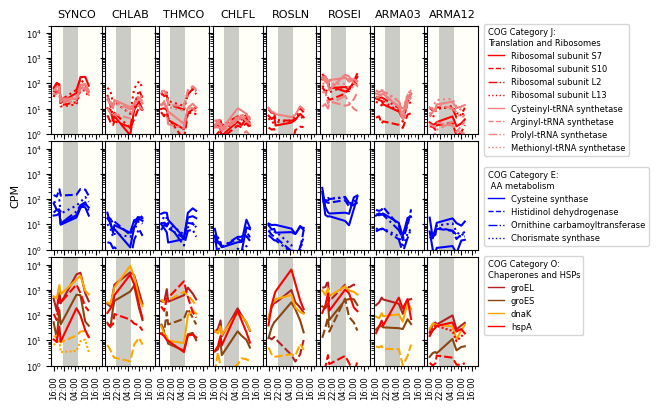

In [94]:
#supplement OS2009
fig, axs = plt.subplots(ncols=8, nrows=3, figsize=(5.5,5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.07,wspace=0.07)
col =0
index=0
plottedlist = []
#category J
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0049"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="red", style="-")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0051"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="red", style="--")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0090"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="red", style="-.")

        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0102"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="red", style=":")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    
    col+=1
col=0

for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0215"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style="-")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0016"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style="--")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0442"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style="-.")

        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0143"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="lightcoral", style=":")
    except:
        pass
    col+=1
col=0
index+=1

#AA synthesis (cat E)
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0031"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style="-")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0141"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style="--")
        
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0078"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style="-.")

        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains("COG0082"))]
        plottedlist.append(p)
        p.filter(like = "Metofsam").T.set_index(os2009dtfake).plot(kind="line",legend=False,ax=axs[index,col],color="blue", style=":")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    
    col+=1
col=0

index+=1


#hsps (cat O)
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 18:00"),pd.to_datetime("2009-07-30 18:00"),
                              facecolor="lightyellow", alpha=0.25)
    axs[index,col].axvspan(pd.to_datetime("2009-07-29 21:10"),pd.to_datetime("2009-07-30 05:41"),
                         facecolor="grey", alpha=0.4)
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(groel)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(os2009dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="firebrick")
    except:
        pass
    axs[index,col].set_yscale("log",base=10)
    axs[index,col].set_ylim([1,20000])
    axs[index,col].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[index,col].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[index,col].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    axs[index,col].tick_params(labelsize=6)
    
    col+=1
col=0
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(groes)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(os2009dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="saddlebrown")
    except:
        pass
    col+=1
col=0
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(dnakjgrpe)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(os2009dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="orange")
    except:
        pass
    col+=1
col=0
for group in strictonepctplotorder:
    df = os2009cpmmeta[os2009cpmmeta["Lineage"]==group]
    try:
        p=df[(df["accession_COG_FUNCTION"].fillna("none").str.contains('|'.join(smallhsp)))]
        plottedlist.append(p)
        pmelt =p.set_index("Gene Cluster").filter(like="Metofsam").T.set_index(os2009dtfake).T.reset_index().melt(id_vars="Gene Cluster",var_name="time", value_name="CPM")
        sns.lineplot(pmelt,x="time",y="CPM", style="Gene Cluster",legend=False,ax=axs[index, col],color="red")
    except:
        pass
    col+=1
col=0

fig.autofmt_xdate(rotation=90, ha="center")

#axis labels
axs[2,0].set_xlabel("")
axs[2,1].set_xlabel("")
axs[2,2].set_xlabel("")
axs[2,3].set_xlabel("")
axs[2,4].set_xlabel("")
axs[2,5].set_xlabel("")
axs[2,6].set_xlabel("")
axs[2,7].set_xlabel("")
axs[0,0].set_ylabel("")
axs[1,0].set_ylabel("CPM", fontsize=8)
axs[2,0].set_ylabel("")




#titles
axs[0,0].set_title(textwrap.fill("SYNCO", 10),fontsize=8, wrap=True)
axs[0,1].set_title(textwrap.fill("CHLAB", 6),fontsize=8, wrap=True)
axs[0,2].set_title(textwrap.fill("THMCO", 6),fontsize=8, wrap=True)
axs[0,3].set_title(textwrap.fill("CHLFL", 6),fontsize=8, wrap=True)
axs[0,4].set_title(textwrap.fill("ROSLN", 8),fontsize=8, wrap=True)
axs[0,5].set_title(textwrap.fill("ROSEI", 8),fontsize=8, wrap=True)
axs[0,6].set_title(textwrap.fill("ARMA03", 8),fontsize=8, wrap=True)
axs[0,7].set_title(textwrap.fill("ARMA12", 10),fontsize=8, wrap=True)


axs[1,0].set_ylabel("CPM", fontsize=8)
#legends
axs[0,7].legend([Line2D([0],[0],color="red",lw=1, linestyle="-"),
                 Line2D([0],[0],color="red",lw=1, linestyle="--"),
                 Line2D([0],[0],color="red",lw=1, linestyle="-."),
                 Line2D([0],[0],color="red",lw=1, linestyle=":"),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle="-"),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle="--"),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle="-."),
                 Line2D([0],[0],color="lightcoral",lw=1, linestyle=":"),
                 ],
                ["Ribosomal subunit S7",
                 "Ribosomal subunit S10",
                 "Ribosomal subunit L2",
                 "Ribosomal subunit L13",
                 "Cysteinyl-tRNA synthetase",
                "Arginyl-tRNA synthetase",
                 "Prolyl-tRNA synthetase",
                 "Methionyl-tRNA synthetase"
                ], bbox_to_anchor=(1.05,1.05), title="COG Category J:\nTranslation and Ribosomes", alignment="left", prop={'size':6}, title_fontsize=6)
axs[1,7].legend([ Line2D([0],[0],color="blue",lw=1, linestyle="-"),
                 Line2D([0],[0],color="blue",lw=1, linestyle="--"),
                 Line2D([0],[0],color="blue",lw=1, linestyle="-."),
                 Line2D([0],[0],color="blue",lw=1, linestyle=":")],
                ["Cysteine synthase",
                "Histidinol dehydrogenase",
                "Ornithine carbamoyltransferase",
                "Chorismate synthase"], 
                bbox_to_anchor=(1.05,0.8), title="COG Category E:\n AA metabolism", alignment="left", prop={'size':6}, title_fontsize=6)
axs[2,7].legend([Line2D([0],[0],color="firebrick",lw=1),Line2D([0],[0],color="saddlebrown",lw=1),Line2D([0],[0],color="orange",lw=1),Line2D([0],[0],color="red",lw=1)],
                ["groEL","groES","dnaK", "hspA"], bbox_to_anchor=(1.05,1.05), title="COG Category O:\nChaperones and HSPs", alignment="left", prop={'size':6}, title_fontsize=6)

#concatenate the plotted df and save
os2009selectgenes = pd.concat(plottedlist)

In [95]:
fig.savefig("Supplementary_fig_9b.png", dpi=300, bbox_inches = "tight")
fig.savefig("Supplementary_fig_9b.svg", dpi=300, bbox_inches = "tight")

In [96]:
#export list of genes used for plotting w/CPM for supplement
ms2005selectgenes[["Lineage", "Gene Cluster","accession_KOFAM","accession_COG_FUNCTION", "MetofsampleMSt1","MetofsampleMSt2","MetofsampleMSt3","MetofsampleMSt4",
               "MetofsampleMSt5","MetofsampleMSt6","MetofsampleMSt7","MetofsampleMSt8",
               "MetofsampleMSt9","MetofsamplMSP12","MetofsamplMSt11","MetofsamplMSt12"]].merge(ms2009selectgenes[["Lineage","Gene Cluster",
                "MetofsampleR2cd","MetofsampleR3cd","MetofsampleR5cd","MetofsampleR6cd",
                "MetofsampleR7cd","MetofsampleR8cd","MetofsampleR9cd","MetofsamplR10cd",
                "MetofsamplR11cd","MetofsamplR12cd","MetofsamplR13cd","MetofsamplR14cd"]], 
                how="left", left_on=["Lineage","Gene Cluster"],right_on=["Lineage","Gene Cluster"]).merge(os2009selectgenes[["Lineage","Gene Cluster",
                "Metofsamplet1cd","Metofsamplet2cd", "Metofsamplet4cd","Metofsamplet5cd",
                "Metofsamplet8cd","Metofsamplt11cd", "Metofsamplt13cd", "Metofsamplt14cd"]],    
                how="left", left_on=["Lineage","Gene Cluster"],right_on=["Lineage","Gene Cluster"]).drop_duplicates().to_excel("SupplementaryData17.xlsx",na_rep="NaN", index=False)

HydDB output for supplement was cleaned up after export

Fig 8 was created in illustration software + associated supplement were exported from original webtools and cleaned up

Supplemental Armatimonadota tree was created with GTDBtk and visualized in iTOL + illustration software